In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [3]:
stocks = ['ABIO',
 'AFKS',
 'AFLT',
 'ALRS',
 'APTK',
 'AQUA',
 'BANE',
 'BANEP',
 'BELU',
 'BSPB',
 'CBOM',
 'CHMF',
 'ENPG',
 'FEES',
 'FESH',
 'FLOT',
 'GAZP',
 'GMKN',
 'GTRK',
 'HEAD',
 'HYDR',
 'IRAO',
 'IRKT',
 'KMAZ',
 'LENT',
 'LIFE',
 'LKOH',
 'LSRG',
 'MAGN',
 'MDMG',
 'MGNT',
 'MOEX',
 'MTLR',
 'MTLRP',
 'MTSS',
 'MVID',
 'NLMK',
 'NMTP',
 'NVTK',
 'OGKB',
 'PHOR',
 'PIKK',
 'PLZL',
 'POSI',
 'RASP',
 'RENI',
 'RNFT',
 'ROSN',
 'RTKM',
 'RTKMP',
 'RUAL',
 'SBER',
 'SBERP',
 'SELG',
 'SFIN',
 'SGZH',
 'SIBN',
 'SMLT',
 'SNGS',
 'SNGSP',
 'SPBE',
 'SVAV',
 'T',
 'TATN',
 'TATNP',
 'TGKN',
 'TRMK',
 'TRNFP',
 'UNAC',
 'UPRO',
 'UWGN',
 'VKCO',
 'VSMO',
 'VTBR',
 'WUSH',
 'YDEX',


#'TMOS',
]

len(stocks)

76

In [6]:
df = load_pkl('./data/feat_engin/lgbm/data_1min.pkl')

In [7]:
df.shape

(4436580, 700)

In [8]:
df.head()

,index,time,close,volume,ticker,tmos_close,close_w1_roc,volume_w1_roc,tmos_close_w1_roc,close_w5_norm_std,...,tmos_close_w20_min/tmos_close_w20_max,close_w30_min/close_w30_max,volume_w30_min/volume_w30_max,tmos_close_w30_min/tmos_close_w30_max,close_w60_min/close_w60_max,volume_w60_min/volume_w60_max,tmos_close_w60_min/tmos_close_w60_max,close_w120_min/close_w120_max,volume_w120_min/volume_w120_max,tmos_close_w120_min/tmos_close_w120_max
0,409,2023-07-04 10:03:00,105.120003,498.0,ABIO,5.52,-0.000760,0.099338,0.000000,0.002112,...,0.998192,0.993567,0.002849,0.998192,0.993567,0.002469,0.998192,0.993567,0.000755,0.998192
1,411,2023-07-04 10:05:00,104.699997,864.0,ABIO,5.51,-0.002667,-0.711712,-0.001812,0.002266,...,0.996383,0.990539,0.001001,0.996383,0.990539,0.001001,0.996383,0.990539,0.000755,0.996383
2,417,2023-07-04 10:11:00,104.599998,438.0,ABIO,5.50,-0.004568,1.354839,-0.001815,0.003970,...,0.994575,0.984863,0.001001,0.994575,0.984863,0.001001,0.994575,0.984863,0.000755,0.994575
3,427,2023-07-04 10:22:00,104.599998,24.0,ABIO,5.50,0.000000,7.000000,0.000000,0.000331,...,0.996377,0.984863,0.001001,0.994575,0.984863,0.001001,0.994575,0.984863,0.000755,0.994575
4,436,2023-07-04 10:31:00,104.300003,336.0,ABIO,5.49,-0.001340,-0.404255,-0.001818,0.001112,...,0.996370,0.988416,0.001001,0.992767,0.984863,0.001001,0.992767,0.984863,0.000755,0.992767


## CHANGE TARGET

In [234]:
def get_target(df_all, ind, val_first, val_second, time_to_wait, time_tick):
    #цель - достичь val_second, не достигнув val_first

    max_points_to_wait = time_to_wait // time_tick
    ind_end = min(ind+max_points_to_wait+1, df_all.shape[0])
    df = df_all.iloc[ind:ind_end].copy()
    
    #mask_time - автоматически и маска на тек. день (10 часов разница между концом и началом осн сессии)
    mask_time = np.array(df['time'] <= df['time'].iloc[0] + time_to_wait)
    df = df.loc[mask_time, :]

    # #mask_stock - работаем внутри одного ticker в тек. версии
    # mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    # df = df.loc[mask_stock, :]


    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: #short game
        mask_val_first = np.array(df['close'] > val_first)
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            if val_first < val_second:
                income_rate = res_price/start_price
            else: #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            if val_first < val_second:
                income_rate = res_price/start_price
            else:  #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first, percent_second, time_to_wait, time_tick):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    for ind in indx:
    #for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, time_to_wait, time_tick)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })

    #макс выигрыш и потери
    if percent_first < percent_second:  
        df_result["income_rate"] = np.maximum(df_result["income_rate"], percent_first) #макс потери
        df_result["income_rate"] = np.minimum(df_result["income_rate"], percent_second) #макс выигрыш
    else:
        df_result["income_rate"] = np.maximum(df_result["income_rate"], 2-percent_first) #макс потери
        df_result["income_rate"] = np.minimum(df_result["income_rate"], 2-percent_second) #макс выигрыш
    
    df_result['income_rate'] -= 0.001
    
    return df_result    

In [658]:
time_wait = pd.Timedelta(hours=3)
time_tick = pd.Timedelta(minutes=1)

df_result = []
for ticker in tqdm(stocks):
    df_target_ticker = load_pkl(f'./tmp/{ticker}.pkl')[['time', 'close', 'ticker']]
    
    mask_ticker = np.array(df['ticker'] == ticker)
    inds_ticker = df.loc[mask_ticker, 'index'].values
    assert (df.loc[mask_ticker, 'time'].values == df_target_ticker.loc[inds_ticker, 'time'].values).all(), 'Error_1'
    
    df_result_ticker = get_df_target(df_target_ticker, inds_ticker, percent_first=0.997, percent_second=1.015,\
                                     time_to_wait=time_wait, time_tick=time_tick)


    assert (df.loc[mask_ticker, 'time'].values == df_result_ticker['time'].values).all(), 'Error_2'
    
    df_result += [df_result_ticker.copy()]

df_result = pd.concat(df_result)

100%|█████████████████████████████████████████████████████████████████████████| 76/76 [16:37<00:00, 13.12s/it]


In [ ]:
df_result

In [659]:
dump_pkl(df_result, './data/feat_engin/lgbm/df_result_-0.3_+1.5_3hour.pkl')

In [660]:
df_result = load_pkl('./data/feat_engin/lgbm/df_result_-0.3_+1.5_3hour.pkl')
df_result

,ind,time,close,result,ticker,delta_time,income_rate,res_price,res_ind
0,409,2023-07-04 10:03:00,105.120003,LOSE,ABIO,0 days 00:02:00,0.996000,104.699997,411
1,411,2023-07-04 10:05:00,104.699997,LOSE,ABIO,0 days 00:01:00,0.996000,104.180000,412
2,417,2023-07-04 10:11:00,104.599998,LOSE,ABIO,0 days 00:23:00,0.996000,103.500000,439
3,427,2023-07-04 10:22:00,104.599998,LOSE,ABIO,0 days 00:12:00,0.996000,103.500000,439
4,436,2023-07-04 10:31:00,104.300003,LOSE,ABIO,0 days 00:03:00,0.996000,103.500000,439
...,...,...,...,...,...,...,...,...,...
64190,321746,2025-02-24 23:11:00,4668.000000,DNF,YDEX,0 days 00:38:00,0.999643,4671.000000,321784
64191,321750,2025-02-24 23:15:00,4662.500000,DNF,YDEX,0 days 00:34:00,1.000823,4671.000000,321784
64192,321765,2025-02-24 23:30:00,4669.000000,DNF,YDEX,0 days 00:19:00,0.999428,4671.000000,321784
64193,321782,2025-02-24 23:47:00,4664.000000,DNF,YDEX,0 days 00:02:00,1.000501,4671.000000,321784


In [661]:
hour_wait = 3
mask_time = np.array((datetime.time(12, 0) <= df['time'].dt.time) & (df['time'].dt.time < datetime.time(23-hour_wait, 30)))
mask_time.mean(), mask_time.sum()

(0.6321387194640917, 2804534)

In [663]:
df_result.loc[mask_time, 'result'].value_counts(normalize=True)

result
LOSE    0.566035
DNF     0.376515
WIN     0.057450
Name: proportion, dtype: float64

In [664]:
# df_result_-0.5_+2_4hour.pkl
# result
# DNF     0.493912
# LOSE    0.455227
# WIN     0.050861
# Name: proportion, dtype: float64

# df_result_-0.5_+1.3_4hour.pkl
# result
# DNF     0.439086
# LOSE    0.448482
# WIN     0.112432
# Name: proportion, dtype: float64

# df_result_-0.5_+1.3_2hour.pkl
# result
# DNF     0.618353
# LOSE    0.317999
# WIN     0.063647
# Name: proportion, dtype: float64

# df_result_-1_+1.3_4hour.pkl
# result
# DNF     0.648653
# LOSE    0.218750
# WIN     0.132597
# Name: proportion, dtype: float64

In [666]:
df_result.loc[mask_time, 'income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.996000
0.01    0.996000
0.10    0.996000
0.20    0.996000
0.30    0.996000
0.40    0.996000
0.50    0.996000
0.60    0.997862
0.70    0.999780
0.80    1.001956
0.90    1.006214
0.99    1.014000
1.00    1.014000
Name: income_rate, dtype: float64

In [667]:
#распределение времени в часах
(df_result.loc[mask_time, 'delta_time']/ pd.Timedelta('1 hour')).quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.000000
0.01    0.016667
0.10    0.133333
0.20    0.300000
0.30    0.533333
0.40    0.883333
0.50    1.416667
0.60    2.333333
0.70    3.000000
0.80    3.000000
0.90    3.000000
0.99    3.000000
1.00    3.000000
Name: delta_time, dtype: float64

In [669]:
(df['index'].values == df_result['ind'].values).all(), (df['close'].values == df_result['close'].values).all(), (df['time'].values == df_result['time'].values).all()

(True, True, True)

In [670]:
df_result.head()

,ind,time,close,result,ticker,delta_time,income_rate,res_price,res_ind
0,409,2023-07-04 10:03:00,105.120003,LOSE,ABIO,0 days 00:02:00,0.996,104.699997,411
1,411,2023-07-04 10:05:00,104.699997,LOSE,ABIO,0 days 00:01:00,0.996,104.180000,412
2,417,2023-07-04 10:11:00,104.599998,LOSE,ABIO,0 days 00:23:00,0.996,103.500000,439
3,427,2023-07-04 10:22:00,104.599998,LOSE,ABIO,0 days 00:12:00,0.996,103.500000,439
4,436,2023-07-04 10:31:00,104.300003,LOSE,ABIO,0 days 00:03:00,0.996,103.500000,439


In [671]:
df.head()

,index,time,close,volume,ticker,tmos_close,close_w1_roc,volume_w1_roc,tmos_close_w1_roc,close_w5_norm_std,close_w5_mean_abs_pct,close_w5_alpha,close_w5_rsi,close_w5_roc,volume_w5_norm_std,volume_w5_mean_abs_pct,volume_w5_alpha,volume_w5_rsi,volume_w5_roc,tmos_close_w5_norm_std,tmos_close_w5_mean_abs_pct,tmos_close_w5_alpha,tmos_close_w5_rsi,tmos_close_w5_roc,close_w10_norm_std,close_w10_mean_abs_pct,close_w10_alpha,close_w10_rsi,close_w10_roc,volume_w10_norm_std,volume_w10_mean_abs_pct,volume_w10_alpha,volume_w10_rsi,volume_w10_roc,tmos_close_w10_norm_std,tmos_close_w10_mean_abs_pct,tmos_close_w10_alpha,tmos_close_w10_rsi,tmos_close_w10_roc,close_w20_norm_std,close_w20_mean_abs_pct,close_w20_alpha,close_w20_rsi,close_w20_roc,volume_w20_norm_std,volume_w20_mean_abs_pct,volume_w20_alpha,volume_w20_rsi,volume_w20_roc,tmos_close_w20_norm_std,...,close_w60_ma_up_2std/close,close_w60_ma_low_3std/close,close_w60_ma_up_3std/close,volume_w60_ma_low_2std/volume,volume_w60_ma_up_2std/volume,volume_w60_ma_low_3std/volume,volume_w60_ma_up_3std/volume,tmos_close_w60_ma_low_2std/tmos_close,tmos_close_w60_ma_up_2std/tmos_close,tmos_close_w60_ma_low_3std/tmos_close,tmos_close_w60_ma_up_3std/tmos_close,close_w120_ma_low_2std/close,close_w120_ma_up_2std/close,close_w120_ma_low_3std/close,close_w120_ma_up_3std/close,volume_w120_ma_low_2std/volume,volume_w120_ma_up_2std/volume,volume_w120_ma_low_3std/volume,volume_w120_ma_up_3std/volume,tmos_close_w120_ma_low_2std/tmos_close,tmos_close_w120_ma_up_2std/tmos_close,tmos_close_w120_ma_low_3std/tmos_close,tmos_close_w120_ma_up_3std/tmos_close,close_w5_min/close_w5_max,volume_w5_min/volume_w5_max,tmos_close_w5_min/tmos_close_w5_max,close_w10_min/close_w10_max,volume_w10_min/volume_w10_max,tmos_close_w10_min/tmos_close_w10_max,close_w20_min/close_w20_max,volume_w20_min/volume_w20_max,tmos_close_w20_min/tmos_close_w20_max,close_w30_min/close_w30_max,volume_w30_min/volume_w30_max,tmos_close_w30_min/tmos_close_w30_max,close_w60_min/close_w60_max,volume_w60_min/volume_w60_max,tmos_close_w60_min/tmos_close_w60_max,close_w120_min/close_w120_max,volume_w120_min/volume_w120_max,tmos_close_w120_min/tmos_close_w120_max,ind,result,delta_time,income_rate,res_price,res_ind,target,ticker_code,y_pred
0,409,2023-07-04 10:03:00,105.120003,498.0,ABIO,5.52,-0.000760,0.099338,0.000000,0.002112,0.002241,-6.568335,50.847645,0.000190,0.724442,9.541154,-0.002155,59.166668,12.833333,0.000991,0.000362,-2.499943e+02,0.000000,-0.001808,0.001840,0.001139,4.893894,50.000000,0.000000,0.899397,7.236273,0.000923,56.086632,54.333332,0.000874,0.000543,-166.662857,33.333332,-0.001808,0.001466,0.000751,17.983786,50.633041,0.000190,1.175322,12.766082,0.006964,53.558395,15.600000,0.000851,...,1.004836,0.995941,1.006615,-0.696165,1.578896,-1.264930,2.147661,0.999652,1.002945,0.998829,1.003768,0.998386,1.005423,0.996626,1.007182,-1.382318,2.175189,-2.271694,3.064566,0.999783,1.002934,0.998995,1.003722,0.994513,0.022792,0.998192,0.994324,0.011396,0.998192,0.993567,0.002849,0.998192,0.993567,0.002849,0.998192,0.993567,0.002469,0.998192,0.993567,0.000755,0.998192,409,LOSE,0 days 00:03:00,0.994,104.18,412,0,0,None
1,411,2023-07-04 10:05:00,104.699997,864.0,ABIO,5.51,-0.002667,-0.711712,-0.001812,0.002266,0.001218,-6.439630,0.000000,-0.006076,1.212911,4.931128,0.000767,53.308231,0.745455,0.001281,0.000724,-2.000002e+02,0.000000,-0.003617,0.002470,0.001520,-4.825096,37.499939,-0.003806,1.315785,5.697942,0.001827,50.739475,0.156627,0.001280,0.000362,-366.665161,0.000000,-0.003617,0.001776,0.000931,2.717369,38.775574,-0.004185,1.471711,13.007571,0.004115,53.850281,287.000000,0.001095,...,1.008814,0.999467,1.010683,-0.750207,1.381920,-1.283238,1.914951,1.001226,1.004884,1.000311,1.005799,1.002103,1.009543,1.000244,1.011402,-0.927374,1.454457,-1.522832,2.049915,1.001436,1.004825,1.000589,1.005672,0.994113,0.008008,0.996383,0.990539,0.004004,0.996383,0.990539,0.003003,0.996383,0.990539,0.001001,0.996383,0.990539,0.001001,0.996383,0.990539,0.000755,0.99638

In [672]:
df[['ind', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']] = df_result[['ind', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']].values

In [673]:
df

,index,time,close,volume,ticker,tmos_close,close_w1_roc,volume_w1_roc,tmos_close_w1_roc,close_w5_norm_std,close_w5_mean_abs_pct,close_w5_alpha,close_w5_rsi,close_w5_roc,volume_w5_norm_std,volume_w5_mean_abs_pct,volume_w5_alpha,volume_w5_rsi,volume_w5_roc,tmos_close_w5_norm_std,tmos_close_w5_mean_abs_pct,tmos_close_w5_alpha,tmos_close_w5_rsi,tmos_close_w5_roc,close_w10_norm_std,close_w10_mean_abs_pct,close_w10_alpha,close_w10_rsi,close_w10_roc,volume_w10_norm_std,volume_w10_mean_abs_pct,volume_w10_alpha,volume_w10_rsi,volume_w10_roc,tmos_close_w10_norm_std,tmos_close_w10_mean_abs_pct,tmos_close_w10_alpha,tmos_close_w10_rsi,tmos_close_w10_roc,close_w20_norm_std,close_w20_mean_abs_pct,close_w20_alpha,close_w20_rsi,close_w20_roc,volume_w20_norm_std,volume_w20_mean_abs_pct,volume_w20_alpha,volume_w20_rsi,volume_w20_roc,tmos_close_w20_norm_std,...,close_w60_ma_up_2std/close,close_w60_ma_low_3std/close,close_w60_ma_up_3std/close,volume_w60_ma_low_2std/volume,volume_w60_ma_up_2std/volume,volume_w60_ma_low_3std/volume,volume_w60_ma_up_3std/volume,tmos_close_w60_ma_low_2std/tmos_close,tmos_close_w60_ma_up_2std/tmos_close,tmos_close_w60_ma_low_3std/tmos_close,tmos_close_w60_ma_up_3std/tmos_close,close_w120_ma_low_2std/close,close_w120_ma_up_2std/close,close_w120_ma_low_3std/close,close_w120_ma_up_3std/close,volume_w120_ma_low_2std/volume,volume_w120_ma_up_2std/volume,volume_w120_ma_low_3std/volume,volume_w120_ma_up_3std/volume,tmos_close_w120_ma_low_2std/tmos_close,tmos_close_w120_ma_up_2std/tmos_close,tmos_close_w120_ma_low_3std/tmos_close,tmos_close_w120_ma_up_3std/tmos_close,close_w5_min/close_w5_max,volume_w5_min/volume_w5_max,tmos_close_w5_min/tmos_close_w5_max,close_w10_min/close_w10_max,volume_w10_min/volume_w10_max,tmos_close_w10_min/tmos_close_w10_max,close_w20_min/close_w20_max,volume_w20_min/volume_w20_max,tmos_close_w20_min/tmos_close_w20_max,close_w30_min/close_w30_max,volume_w30_min/volume_w30_max,tmos_close_w30_min/tmos_close_w30_max,close_w60_min/close_w60_max,volume_w60_min/volume_w60_max,tmos_close_w60_min/tmos_close_w60_max,close_w120_min/close_w120_max,volume_w120_min/volume_w120_max,tmos_close_w120_min/tmos_close_w120_max,ind,result,delta_time,income_rate,res_price,res_ind,target,ticker_code,y_pred
0,409,2023-07-04 10:03:00,105.120003,498.0,ABIO,5.52,-0.000760,0.099338,0.000000,0.002112,0.002241,-6.568335,50.847645,0.000190,0.724442,9.541154,-0.002155,59.166668,12.833333,0.000991,0.000362,-2.499943e+02,0.000000,-0.001808,0.001840,0.001139,4.893894,50.000000,0.000000,0.899397,7.236273,0.000923,56.086632,54.333332,0.000874,0.000543,-166.662857,33.333332,-0.001808,0.001466,0.000751,17.983786,50.633041,0.000190,1.175322,12.766082,0.006964,53.558395,15.600000,0.000851,...,1.004836,0.995941,1.006615,-0.696165,1.578896,-1.264930,2.147661,0.999652,1.002945,0.998829,1.003768,0.998386,1.005423,0.996626,1.007182,-1.382318,2.175189,-2.271694,3.064566,0.999783,1.002934,0.998995,1.003722,0.994513,0.022792,0.998192,0.994324,0.011396,0.998192,0.993567,0.002849,0.998192,0.993567,0.002849,0.998192,0.993567,0.002469,0.998192,0.993567,0.000755,0.998192,409,LOSE,0 days 00:02:00,0.996,104.699997,411,0,0,None
1,411,2023-07-04 10:05:00,104.699997,864.0,ABIO,5.51,-0.002667,-0.711712,-0.001812,0.002266,0.001218,-6.439630,0.000000,-0.006076,1.212911,4.931128,0.000767,53.308231,0.745455,0.001281,0.000724,-2.000002e+02,0.000000,-0.003617,0.002470,0.001520,-4.825096,37.499939,-0.003806,1.315785,5.697942,0.001827,50.739475,0.156627,0.001280,0.000362,-366.665161,0.000000,-0.003617,0.001776,0.000931,2.717369,38.775574,-0.004185,1.471711,13.007571,0.004115,53.850281,287.000000,0.001095,...,1.008814,0.999467,1.010683,-0.750207,1.381920,-1.283238,1.914951,1.001226,1.004884,1.000311,1.005799,1.002103,1.009543,1.000244,1.011402,-0.927374,1.454457,-1.522832,2.049915,1.001436,1.004825,1.000589,1.005672,0.994113,0.008008,0.996383,0.990539,0.004004,0.996383,0.990539,0.003003,0.996383,0.990539,0.001001,0.996383,0.990539,0.001001,0.996383,0.990539,0.000755,0.9

In [674]:
assert (df['index'] == df['ind']).all(), 'Error'

In [676]:
#проверить данные

mask = df['time'] >= pd.Timestamp('2025-02-01')


i = 3730
cols = ['ticker', 'time', 'close', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']
df.loc[mask&mask_time, cols].iloc[i:i+10]

,ticker,time,close,result,delta_time,income_rate,res_price,res_ind
173250,AFLT,2025-02-18 12:15:00,72.330002,WIN,0 days 00:53:00,1.014,73.419998,337566
173251,AFLT,2025-02-18 12:17:00,72.639999,LOSE,0 days 00:03:00,0.996,72.419998,337518
173252,AFLT,2025-02-18 12:29:00,72.309998,WIN,0 days 00:39:00,1.014,73.419998,337566
173253,AFLT,2025-02-18 12:30:00,72.309998,WIN,0 days 00:38:00,1.014,73.419998,337566
173254,AFLT,2025-02-18 12:31:00,72.339996,WIN,0 days 02:27:00,1.014,73.639999,337676
173255,AFLT,2025-02-18 12:32:00,72.389999,WIN,0 days 02:26:00,1.014,73.639999,337676
173256,AFLT,2025-02-18 12:48:00,73.190002,LOSE,0 days 00:06:00,0.996,72.830002,337552
173257,AFLT,2025-02-18 12:52:00,73.000000,LOSE,0 days 00:05:00,0.996,72.720001,337555
173258,AFLT,2025-02-18 12:53:00,73.080002,LOSE,0 days 00:01:00,0.996,72.830002,337552
173259,AFLT,2025-02-18 12:54:00,72.830002,WIN,0 days 02:06:00,1.014,74.269997,337678


### 1. train/valid/test/test2 split

In [681]:
df['target'] = (df['result'] == 'WIN').astype(int)

<Axes: xlabel='time'>

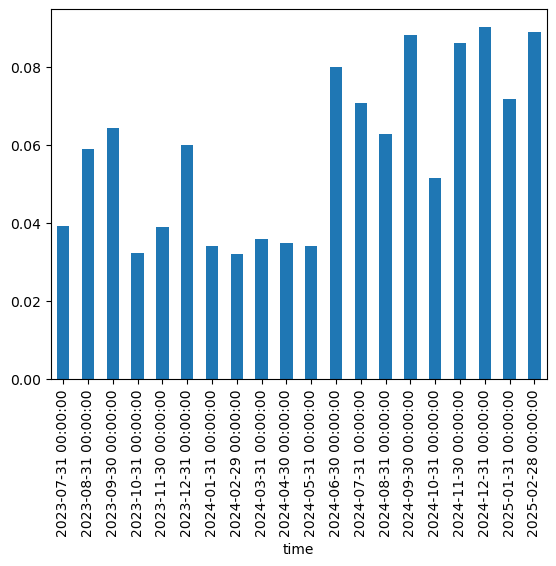

In [684]:
df.loc[mask_time, ['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

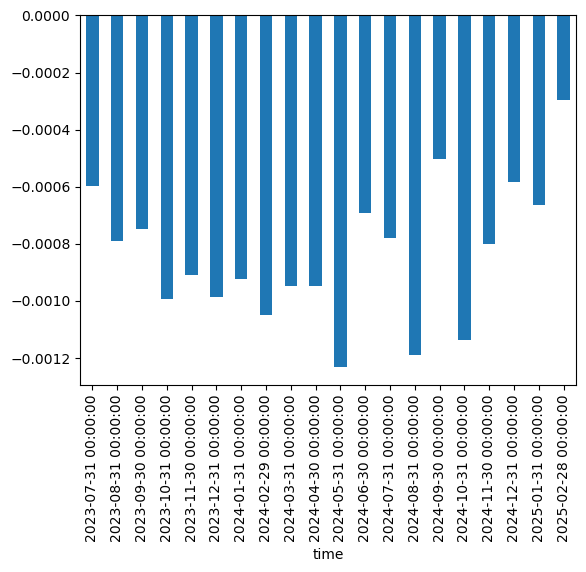

In [685]:
(df.loc[mask_time, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [687]:
pd.set_option('display.max_rows', 150)
df.loc[mask_time, ['ticker', 'target']].groupby('ticker').target.mean().sort_values()

ticker
SBERP    0.014935
SBER     0.017029
LKOH     0.020053
IRAO     0.020803
MTSS     0.024734
TATNP    0.024851
ROSN     0.025678
TATN     0.026644
PHOR     0.029179
PLZL     0.029267
NVTK     0.033395
TRNFP    0.034996
GAZP     0.035483
SIBN     0.037374
HYDR     0.037498
SNGSP    0.038217
MAGN     0.039137
BELU     0.039382
GMKN     0.039817
MOEX     0.041657
CHMF     0.042347
VTBR     0.042712
T        0.043004
ALRS     0.043690
AQUA     0.044557
RTKMP    0.046452
POSI     0.047427
SNGS     0.047802
UPRO     0.048513
MGNT     0.048833
BSPB     0.048956
YDEX     0.049477
NLMK     0.051541
RTKM     0.053693
RUAL     0.053848
BANEP    0.054931
VKCO     0.055025
OGKB     0.055789
FLOT     0.056639
AFLT     0.058952
ENPG     0.060368
MDMG     0.063234
CBOM     0.063627
WUSH     0.064524
SMLT     0.065241
FEES     0.066104
SGZH     0.067635
TRMK     0.068273
APTK     0.070709
KMAZ     0.071907
BANE     0.072261
VSMO     0.072510
RASP     0.073412
MVID     0.073475
SELG     0.073791
AFK

In [688]:
df.loc[mask_time, ['ticker', 'income_rate']].groupby('ticker').income_rate.mean().sort_values()

ticker
APTK     0.998572
SPBE     0.998719
VKCO     0.998732
LIFE     0.998746
UWGN     0.998769
ABIO     0.998806
IRKT     0.998851
SVAV     0.998854
AQUA     0.998857
UNAC     0.998865
WUSH     0.998895
BELU     0.998949
VSMO     0.998955
RTKMP    0.998957
VTBR     0.998961
UPRO     0.998972
SGZH     0.998991
SNGS     0.998992
SBERP    0.999004
NMTP     0.999005
GAZP     0.999028
TGKN     0.999033
TRNFP    0.999036
SBER     0.999046
BSPB     0.999047
GTRK      0.99905
RNFT     0.999055
GMKN     0.999066
KMAZ     0.999081
TRMK     0.999083
IRAO     0.999093
SFIN     0.999095
TATNP      0.9991
NVTK     0.999102
ALRS     0.999111
SELG     0.999129
T        0.999143
FEES     0.999144
MDMG     0.999148
YDEX     0.999156
HYDR     0.999159
LKOH     0.999177
TATN     0.999181
PLZL     0.999187
ENPG     0.999192
POSI     0.999194
ROSN     0.999197
LENT     0.999206
MVID     0.999206
SNGSP    0.999227
PHOR     0.999228
RTKM     0.999249
MGNT     0.999253
RUAL     0.999275
BANEP    0.999276
SML

In [691]:
df['time'].max()

Timestamp('2025-02-24 23:49:00')

In [692]:
mask_train = np.array(df['time'] < pd.Timestamp('2024-07-01')) & mask_time
mask_valid = np.array((pd.Timestamp('2024-07-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-09-01'))) & mask_time
mask_test = np.array((pd.Timestamp('2024-09-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-11-01'))) & mask_time
mask_test2 = np.array((pd.Timestamp('2024-11-01') <= df['time']) & (df['time'] < pd.Timestamp('2025-01-01'))) & mask_time
mask_test3 = np.array(pd.Timestamp('2025-01-01') <= df['time']) & mask_time

In [693]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1678568, 296002, 294425, 283563)

In [694]:
mask_test3.sum()

251976

In [696]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

2552558

In [698]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.657602295422866,
 0.11596288899214044,
 0.11534507736944664,
 0.11108973821554692)

In [700]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.04528681590498568,
 0.06678333254505037,
 0.06919249384393308,
 0.08825551993736841)

In [701]:
df.loc[mask_test3, 'target'].mean()

0.07912658348414135

In [703]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(0.9990956088967224, 0.999021106977962, 0.9991688566585647, 0.9993119785725331)

In [704]:
df.loc[mask_test3, 'income_rate'].mean()

0.9994954167956791

In [707]:
#проверки

In [708]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

## 3. Model

### 3.1 Base model

In [712]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

In [713]:
df['ticker_code'].nunique()

76

In [714]:
df.loc[mask_train, 'ticker_code'].nunique()

76

In [716]:
drop_cols = [
 'time',
 'close',
 'volume',
 'tmos_close',
 'ticker',


     'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind',

    'index',
    'ind',
    
             'target',
             'y_pred']


features_all = df.columns[~df.columns.isin(drop_cols)].tolist()

cat_features_all = ['ticker_code',
                'hour', 'day', 'weekday',
]
cat_features = cat_features_all

target = 'target'

In [717]:
len(features_all), len(cat_features)

(695, 4)

### 1. PSI

In [720]:
def psi(expected: np.ndarray, actual: np.ndarray, bucket_type: str = "bins", n_bins: int = 10) -> float:
    """Calculate PSI metric for two arrays.
    
    Parameters
    ----------
        expected : list-like
            Array of expected values
        actual : list-like
            Array of actual values
        bucket_type : str
            Binning strategy. Accepts two options: 'bins' and 'quantiles'. Defaults to 'bins'.
            'bins': input arrays are splitted into bins with equal
                and fixed steps based on 'expected' array
            'quantiles': input arrays are binned according to 'expected' array
                with given number of n_bins
        n_bins : int
            Number of buckets for binning. Defaults to 10.

    Returns
    -------
        A single float number
    """
    breakpoints = np.arange(0, n_bins + 1) / (n_bins) * 100
    if bucket_type == "bins":
        breakpoints = np.histogram(expected, n_bins)[1]
    elif bucket_type == "quantiles":
        breakpoints = np.percentile(expected, breakpoints)

    # Calculate frequencies
    expected_percents = np.histogram(expected, breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, breakpoints)[0] / len(actual)
    # Clip freaquencies to avoid zero division
    expected_percents = np.clip(expected_percents, a_min=0.0001, a_max=None)
    actual_percents = np.clip(actual_percents, a_min=0.0001, a_max=None)
    # Calculate PSI
    psi_value = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
    psi_value = sum(psi_value)

    return psi_value

In [723]:
psi_features = {'feature' : [],
                
               'psi_valid' : [],
               'psi_test' : [],
               'psi_test2' : [],

               'psi_neg_valid' : [],
               'psi_neg_test' : [],
               'psi_neg_test2' : [],

               'psi_pos_valid' : [],
               'psi_pos_test' : [],
               'psi_pos_test2' : [],
               }

for feature in tqdm(features_all):

    mask_pos = df['target'] == 1
    mask_neg = ~mask_pos

    psi_features['feature'] += [feature]
    
    psi_features['psi_valid'] += [psi(df.loc[mask_train, feature].values, df.loc[mask_valid, feature].values)]
    psi_features['psi_test'] += [psi(df.loc[mask_train, feature].values, df.loc[mask_test, feature].values)]
    psi_features['psi_test2'] += [psi(df.loc[mask_train, feature].values, df.loc[mask_test2, feature].values)]

    psi_features['psi_neg_valid'] += [psi(df.loc[mask_train&mask_neg, feature].values, df.loc[mask_valid&mask_neg, feature].values)]
    psi_features['psi_neg_test'] += [psi(df.loc[mask_train&mask_neg, feature].values, df.loc[mask_test&mask_neg, feature].values)]
    psi_features['psi_neg_test2'] += [psi(df.loc[mask_train&mask_neg, feature].values, df.loc[mask_test2&mask_neg, feature].values)]

    psi_features['psi_pos_valid'] += [psi(df.loc[mask_train&mask_pos, feature].values, df.loc[mask_valid&mask_pos, feature].values)]
    psi_features['psi_pos_test'] += [psi(df.loc[mask_train&mask_pos, feature].values, df.loc[mask_test&mask_pos, feature].values)]
    psi_features['psi_pos_test2'] += [psi(df.loc[mask_train&mask_pos, feature].values, df.loc[mask_test2&mask_pos, feature].values)]

df_psi = pd.DataFrame(psi_features)

100%|███████████████████████████████████████████████████████████████████████| 695/695 [07:08<00:00,  1.62it/s]


In [724]:
df_psi.head()

,feature,psi_valid,psi_test,psi_test2,psi_neg_valid,psi_neg_test,psi_neg_test2,psi_pos_valid,psi_pos_test,psi_pos_test2
0,close_w1_roc,1.376573e-03,0.002308,0.005903,4.289744e-04,0.000421,0.001893,0.001434,0.000633,0.000555
1,volume_w1_roc,3.779342e-09,0.000007,0.000010,3.357925e-09,0.000004,0.000005,0.000003,0.000204,0.000069
2,tmos_close_w1_roc,4.085393e-02,0.020848,0.043021,4.095873e-02,0.020477,0.044239,0.049984,0.047176,0.179850
3,close_w5_norm_std,1.171241e-05,0.000003,0.000050,4.783094e-05,0.000074,0.000320,0.000134,0.002921,0.000816
4,close_w5_mean_abs_pct,7.757951e-05,0.000019,0.000349,2.157990e-04,0.000436,0.001670,0.003692,0.005729,0.003550


In [725]:
psi_threshold = 0.1
mask_psi_pos_neg = (df_psi['psi_valid'] < psi_threshold) & (df_psi['psi_test'] < psi_threshold) & (df_psi['psi_test2'] < psi_threshold)
mask_psi_neg = (df_psi['psi_neg_valid'] < psi_threshold) & (df_psi['psi_neg_test'] < psi_threshold) & (df_psi['psi_neg_test2'] < psi_threshold)
mask_psi_pos = (df_psi['psi_pos_valid'] < psi_threshold) & (df_psi['psi_pos_test'] < psi_threshold) & (df_psi['psi_pos_test2'] < psi_threshold)


In [726]:
len(features_all)

695

In [727]:
mask_psi_pos_neg.sum(), (mask_psi_pos_neg & mask_psi_neg & mask_psi_pos).sum()

(544, 528)

In [728]:
mask_psi = mask_psi_pos_neg & mask_psi_neg & mask_psi_pos

In [729]:
np.array(features_all)[mask_psi]

array(['close_w1_roc', 'volume_w1_roc', 'close_w5_norm_std',
       'close_w5_mean_abs_pct', 'close_w5_alpha', 'close_w5_rsi',
       'close_w5_roc', 'volume_w5_norm_std', 'volume_w5_mean_abs_pct',
       'volume_w5_alpha', 'volume_w5_rsi', 'volume_w5_roc',
       'tmos_close_w5_alpha', 'tmos_close_w5_rsi', 'tmos_close_w5_roc',
       'close_w10_norm_std', 'close_w10_mean_abs_pct', 'close_w10_alpha',
       'close_w10_rsi', 'close_w10_roc', 'volume_w10_norm_std',
       'volume_w10_mean_abs_pct', 'volume_w10_alpha', 'volume_w10_rsi',
       'volume_w10_roc', 'tmos_close_w10_alpha', 'close_w20_norm_std',
       'close_w20_mean_abs_pct', 'close_w20_alpha', 'close_w20_rsi',
       'close_w20_roc', 'volume_w20_norm_std', 'volume_w20_mean_abs_pct',
       'volume_w20_alpha', 'volume_w20_rsi', 'volume_w20_roc',
       'close_w30_norm_std', 'close_w30_mean_abs_pct', 'close_w30_alpha',
       'close_w30_rsi', 'close_w30_roc', 'volume_w30_norm_std',
       'volume_w30_mean_abs_pct', 'volume_w30

In [730]:
features_psi = np.array(features_all)[mask_psi]
len(features_psi)

528

### 2. Correlation

In [129]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1828415, 327593, 326131, 314270)

In [131]:
#subsample_train

coeff_subsample = 0.1

inds_train = np.argwhere(mask_train).ravel()
inds_train_subsample = np.random.RandomState(seed=42).permutation(inds_train)[:int(len(inds_train)*coeff_subsample)]

mask_train_subsample = np.zeros_like(mask_train).astype(bool)
mask_train_subsample[inds_train_subsample] = True

mask_train_subsample.sum()

182841

In [362]:
features = features_psi.copy()
len(features)

528

In [364]:
mask_corr = np.ones_like(features).astype(bool)
#mask_corr

In [366]:
corr_threshold = 0.99

for i in tqdm(range(len(features) - 1)):
    if mask_corr[i]:
        for j in range(i+1, len(features)):
            if mask_corr[j]:        
                corr = abs(np.corrcoef(df.loc[mask_train_subsample, features[i]], df.loc[mask_train_subsample, features[j]])[0,1])
                if corr > corr_threshold:
                    mask_corr[j] = False
mask_corr.sum()

100%|███████████████████████████████████████████████████████████████████████| 527/527 [19:15<00:00,  2.19s/it]


474

In [378]:
np.array(features)[~mask_corr]

array(['close_w5_alpha/close_w60_alpha',
       'close_w5_alpha/close_w120_alpha',
       'close_w10_alpha/close_w120_alpha',
       'close_w20_alpha/close_w30_alpha',
       'close_w20_alpha/close_w120_alpha',
       'close_w30_alpha/close_w60_alpha',
       'close_w30_alpha/close_w120_alpha',
       'close_w60_alpha/close_w120_alpha',
       'close_w5_norm_std/close_w10_norm_std',
       'close_w5_norm_std/close_w20_norm_std',
       'close_w5_norm_std/close_w30_norm_std',
       'close_w5_norm_std/close_w60_norm_std',
       'close_w5_norm_std/close_w120_norm_std',
       'close_w10_norm_std/close_w20_norm_std',
       'close_w10_norm_std/close_w30_norm_std',
       'close_w10_norm_std/close_w60_norm_std',
       'close_w10_norm_std/close_w120_norm_std',
       'close_w20_norm_std/close_w30_norm_std',
       'close_w20_norm_std/close_w60_norm_std',
       'close_w20_norm_std/close_w120_norm_std',
       'close_w30_norm_std/close_w60_norm_std',
       'close_w30_norm_std/close_w120_n

In [367]:
features_corr = np.array(features)[mask_corr]
len(features_corr)

474

In [368]:
features_corr

array(['close_w1_roc', 'volume_w1_roc', 'close_w5_norm_std',
       'close_w5_mean_abs_pct', 'close_w5_alpha', 'close_w5_rsi',
       'close_w5_roc', 'volume_w5_norm_std', 'volume_w5_mean_abs_pct',
       'volume_w5_alpha', 'volume_w5_rsi', 'volume_w5_roc',
       'tmos_close_w5_alpha', 'tmos_close_w5_rsi', 'tmos_close_w5_roc',
       'close_w10_norm_std', 'close_w10_mean_abs_pct', 'close_w10_alpha',
       'close_w10_rsi', 'close_w10_roc', 'volume_w10_norm_std',
       'volume_w10_mean_abs_pct', 'volume_w10_alpha', 'volume_w10_rsi',
       'volume_w10_roc', 'tmos_close_w10_alpha', 'close_w20_norm_std',
       'close_w20_mean_abs_pct', 'close_w20_alpha', 'close_w20_rsi',
       'close_w20_roc', 'volume_w20_norm_std', 'volume_w20_mean_abs_pct',
       'volume_w20_alpha', 'volume_w20_rsi', 'volume_w20_roc',
       'tmos_close_w20_alpha', 'close_w30_norm_std',
       'close_w30_mean_abs_pct', 'close_w30_alpha', 'close_w30_rsi',
       'close_w30_roc', 'volume_w30_norm_std', 'volume_w30_me

#### 2. Useful features

In [731]:
def get_useful_features(feature):
    for elem in ['volume', 'std', 'pct', 'alpha', 'rsi/', 'roc', 'ticker_code', 'hour', '_ma']:
        if elem in feature:
            return False
    return True

mask_useful_features = np.array([get_useful_features(feature) for feature in features_psi])
features_useful = np.array(features_psi)[mask_useful_features].tolist()
len(features_useful), features_useful


(66,
 ['close_w5_rsi',
  'tmos_close_w5_rsi',
  'close_w10_rsi',
  'close_w20_rsi',
  'close_w30_rsi',
  'close_w30_lvl_1-1.005',
  'close_w30_lvl_-0.995-1',
  'close_w30_lvl_1.005-1.01',
  'close_w30_lvl_-0.99-0.995',
  'close_w30_lvl_1.01-1.015',
  'close_w30_lvl_-0.985-0.99',
  'close_w30_lvl_1.015-1.02',
  'close_w30_lvl_-0.98-0.985',
  'close_w30_lvl_1.02-1.03',
  'close_w30_lvl_-0.97-0.98',
  'tmos_close_w30_lvl_-0.995-1',
  'tmos_close_w30_lvl_1.01-1.015',
  'tmos_close_w30_lvl_-0.985-0.99',
  'tmos_close_w30_lvl_1.015-1.02',
  'tmos_close_w30_lvl_-0.98-0.985',
  'tmos_close_w30_lvl_1.02-1.03',
  'tmos_close_w30_lvl_-0.97-0.98',
  'close_w60_rsi',
  'close_w120_rsi',
  'close_w120_lvl_-0.995-1',
  'close_w120_lvl_1.005-1.01',
  'close_w120_lvl_-0.99-0.995',
  'close_w120_lvl_1.01-1.015',
  'close_w120_lvl_-0.985-0.99',
  'close_w120_lvl_1.015-1.02',
  'close_w120_lvl_-0.98-0.985',
  'close_w120_lvl_1.02-1.03',
  'close_w120_lvl_-0.97-0.98',
  'tmos_close_w120_lvl_1.01-1.015',
  

### 3. Get stability features

In [734]:
features = features_useful.copy()
len(features)

66

In [736]:
#Перепроверить эти функции потом в ручную на примерах

def mean_win_rate_point(D_sample, y_pred, threshold=None):
    mask = y_pred >= threshold
    score = np.mean(D_sample.label[mask])
    
    return score




def mean_income_rate_point(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_tick(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup[mask].groupby('time').income_rate.mean()-1).mean()
    
    return score



def mean_income_rate_day(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup[mask].groupby('time').income_rate.mean()-1).reset_index().groupby(pd.Grouper(key='time', freq='D')).income_rate.mean().mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup[mask].groupby('time').income_rate.mean()-1).reset_index().groupby(pd.Grouper(key='time', freq='D')).income_rate.mean().mean() * df_sup.loc[mask, 'time'].dt.date.nunique() 
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score


def mean_income_rate(y_pred, D_sample):
    q = 0.995
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    # month
    # score = (df_sup[mask].groupby('time').income_rate.mean()-1).reset_index().groupby(pd.Grouper(key='time', freq='D')).income_rate.mean().mean() * df_sup.loc[mask, 'time'].dt.date.nunique() 
    # score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month

    # tick
    score = (df_sup[mask].groupby('time').income_rate.mean()-1).mean()
    
    # point
    # score = np.mean(D_sample.income_rate[mask]) - 1

    #point win_rate
    # score = np.mean(D_sample.label[mask])

    score = round(score, 5)
    return 'mean_income_rate', score, True#is_higher_better





In [737]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    "num_leaves": 31,

     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     "verbose": -1,
    # "metric": "auc",
    "metric": "mean_income_rate",   
    "early_stopping" : 10, 
    
    
}

auc_features = {'feature' : [],
                
               'auc_train' : [],
               'auc_valid' : [],
               'auc_test' : [],
               'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_tick@1_train' : [],
           'mir_tick@1_valid' : [],
           'mir_tick@1_test' : [],
           'mir_tick@1_test2' : [],


           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],

           'mean_win_rate_point@1_train' : [],
           'mean_win_rate_point@1_valid' : [],
           'mean_win_rate_point@1_test' : [],
           'mean_win_rate_point@1_test2' : [],

        
               }

for feature in tqdm(features):
    stab_features = [feature]
    stab_cat_features = [feature] if feature in cat_features else []
    
    D_train = lgbm.Dataset(df.loc[mask_train_subsample, stab_features], label=df.loc[mask_train_subsample, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, stab_features], label=df.loc[mask_valid, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, stab_features], label=df.loc[mask_test, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, stab_features], label=df.loc[mask_test2, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)

    D_train.income_rate = df.loc[mask_train_subsample, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values
    
    D_train.time = df.loc[mask_train_subsample, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values


    
    model = lgbm.train(params, num_boost_round=1000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)
    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)

    auc_features['feature'] += [feature]
    auc_features['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    auc_features['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    auc_features['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    auc_features['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

    
    threshold = np.quantile(y_pred_valid, q=0.995) #в feval тоже нужно менять
    
    auc_features['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold)]
    auc_features['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold)]
    auc_features['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold)]
    auc_features['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)]

    auc_features['mir_tick@1_train'] += [mean_income_rate_tick(D_train, y_pred_train, threshold=threshold)]
    auc_features['mir_tick@1_valid'] += [mean_income_rate_tick(D_valid, y_pred_valid, threshold=threshold)]
    auc_features['mir_tick@1_test'] += [mean_income_rate_tick(D_test, y_pred_test, threshold=threshold)]
    auc_features['mir_tick@1_test2'] += [mean_income_rate_tick(D_test2, y_pred_test2, threshold=threshold)]

    auc_features['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold)]
    auc_features['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold)]
    auc_features['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold)]
    auc_features['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)]

    
    auc_features['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold)]
    auc_features['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold)]
    auc_features['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold)]
    auc_features['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)]

    auc_features['mean_win_rate_point@1_train'] += [mean_win_rate_point(D_train, y_pred_train, threshold=threshold)]
    auc_features['mean_win_rate_point@1_valid'] += [mean_win_rate_point(D_valid, y_pred_valid, threshold=threshold)]
    auc_features['mean_win_rate_point@1_test'] += [mean_win_rate_point(D_test, y_pred_test, threshold=threshold)]
    auc_features['mean_win_rate_point@1_test2'] += [mean_win_rate_point(D_test2, y_pred_test2, threshold=threshold)]

df_auc = pd.DataFrame(auc_features)

100%|█████████████████████████████████████████████████████████████████████████| 66/66 [03:09<00:00,  2.87s/it]


In [739]:
pd.set_option('display.max_columns', 100)
df_auc = pd.DataFrame(auc_features)
df_auc

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_tick@1_train,mir_tick@1_valid,mir_tick@1_test,mir_tick@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mean_win_rate_point@1_train,mean_win_rate_point@1_valid,mean_win_rate_point@1_test,mean_win_rate_point@1_test2
0,close_w5_rsi,0.560984,0.515133,0.521250,0.512149,-0.000596,-0.000734,-0.000683,-0.000569,-0.000608,-0.000737,-0.000677,-0.000603,-0.000440,-0.000690,-0.000615,-0.000595,-0.009486,-0.015183,-0.013521,-0.013100,0.081719,0.083866,0.091500,0.100130
1,tmos_close_w5_rsi,0.520450,0.516235,0.506772,0.514833,-0.000047,-0.001076,-0.000858,-0.000214,-0.000089,-0.000965,-0.000954,0.000068,-0.000318,-0.001338,-0.001063,-0.000298,-0.004634,-0.028793,-0.023375,-0.006247,0.098494,0.081687,0.100645,0.144728
2,close_w10_rsi,0.535185,0.508000,0.503682,0.502810,-0.000811,-0.000958,-0.000926,-0.000556,-0.000808,-0.000945,-0.000920,-0.000537,-0.000755,-0.000890,-0.000883,-0.000605,-0.016226,-0.019578,-0.019428,-0.013320,0.063934,0.069253,0.078111,0.100191
3,close_w20_rsi,0.552064,0.509430,0.506373,0.505311,-0.000754,-0.000804,-0.000723,-0.000748,-0.000770,-0.000829,-0.000749,-0.000715,-0.000710,-0.001014,-0.000941,-0.000828,-0.015368,-0.022313,-0.020695,-0.018212,0.069644,0.084275,0.079414,0.088248
4,close_w30_rsi,0.535384,0.502687,0.499598,0.507103,-0.000861,-0.000936,-0.000957,-0.000919,-0.000850,-0.000974,-0.000951,-0.000918,-0.000963,-0.001209,-0.001137,-0.001183,-0.020868,-0.026594,-0.025009,-0.026028,0.058346,0.072762,0.075034,0.087996
5,close_w30_lvl_1-1.005,0.557556,0.541260,0.539321,0.529017,-0.000908,-0.001014,-0.000769,-0.000589,-0.000907,-0.000991,-0.000771,-0.000582,-0.000925,-0.000998,-0.000769,-0.000612,-0.020358,-0.021958,-0.016914,-0.013464,0.052642,0.074270,0.077687,0.100288
6,close_w30_lvl_-0.995-1,0.532611,0.515096,0.515603,0.521129,-0.000844,-0.000936,-0.000940,-0.000717,-0.000852,-0.000899,-0.000931,-0.000730,-0.000851,-0.000871,-0.000911,-0.000756,-0.018725,-0.019172,-0.020045,-0.016638,0.049863,0.074397,0.069152,0.093980
7,close_w30_lvl_1.005-1.01,0.568666,0.545641,0.550436,0.545098,-0.000289,-0.000600,-0.000759,-0.000412,-0.000280,-0.000547,-0.000669,-0.000338,0.000413,0.000021,-0.000196,-0.000004,0.008443,0.000455,-0.004315,-0.000097,0.108158,0.105352,0.093970,0.116619
8,close_w30_lvl_-0.99-0.995,0.570619,0.541695,0.542759,0.530910,-0.000742,-0.001283,-0.001199,-0.001038,-0.000752,-0.001346,-0.001246,-0.001129,-0.000990,-0.001662,-0.001599,-0.001501,-0.021686,-0.036559,-0.035188,-0.033032,0.120341,0.101138,0.102064,0.114197
9,close_w30_lvl_1.01-1.015,0.531907,0.523599,0.525026,0.522052,0.000289,-0.000384,-0.000230,0.000051,0.000326,-0.000328,-0.000173,0.000151,0.000575,0.000026,0.000359,0.000367,0.008869,0.000575,0.007894,0.008067,0.180743,0.145132,0.144476,0.163573


#### auc <=0.525

In [3532]:
auc_treshold = 0.51

In [3534]:
mask_auc_train  = df_auc['auc_train'] <= auc_treshold 
mask_auc_train.sum()

13

In [1706]:
mask_auc_valid  = df_auc['auc_valid'] <= auc_treshold 
mask_auc_valid.sum()

271

In [1708]:
mask_auc_test  = df_auc['auc_test'] <= auc_treshold 
mask_auc_test.sum()

264

In [1710]:
(mask_auc_train | mask_auc_valid | mask_auc_test).sum()

311

In [1712]:
mask_auc_test2  = df_auc['auc_test2'] <= auc_treshold 
mask_auc_test2.sum()

249

In [1714]:
(mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2).sum()

324

#### delta_auc > 0.05

In [1719]:
auc_delta_treshold  = 0.025

In [1725]:
mask_auc_delta_valid = (df_auc['auc_train'] - df_auc['auc_valid']).abs() > auc_delta_treshold
mask_auc_delta_valid.sum()

115

In [1727]:
mask_auc_delta_test = (df_auc['auc_train'] - df_auc['auc_test']).abs() > auc_delta_treshold
mask_auc_delta_test.sum()

114

In [1729]:
(mask_auc_delta_valid | mask_auc_delta_test).sum()

128

In [1731]:
mask_auc_delta_test2 = (df_auc['auc_train'] - df_auc['auc_test2']).abs() > auc_delta_treshold
mask_auc_delta_test2.sum()

120

In [1733]:
(mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2).sum()

135

#### union criterias

In [1739]:
mask_criterias1 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_delta_valid | mask_auc_delta_test
mask_criterias1.sum()

417

In [1741]:
mask_criterias2 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2 | mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2
mask_criterias2.sum()

433

In [1746]:
features_criteria1 = df_auc['feature'].values[~mask_criterias1]
len(features_criteria1), features_criteria1

(57,
 array(['tmos_close_w5_roc', 'volume_w30_rsi', 'close_w30_lvl_1-1.005',
        'close_w30_lvl_-0.995-1', 'close_w30_lvl_1.005-1.01',
        'close_w30_lvl_-0.99-0.995', 'close_w30_lvl_1.01-1.015',
        'close_w30_lvl_-0.985-0.99', 'tmos_close_w30_lvl_-0.995-1',
        'close_w60_rsi', 'volume_w60_rsi', 'volume_w120_rsi',
        'close_w120_lvl_1.01-1.015', 'close_w120_lvl_1.015-1.02',
        'close_w120_lvl_-0.98-0.985', 'close_w120_lvl_1.02-1.03',
        'close_w120_lvl_-0.97-0.98', 'hour',
        'volume_w5_alpha/volume_w60_alpha',
        'volume_w5_alpha/volume_w120_alpha',
        'tmos_close_w1_roc/tmos_close_w120_alpha',
        'tmos_close_w5_alpha/tmos_close_w10_alpha',
        'tmos_close_w5_alpha/tmos_close_w30_alpha',
        'tmos_close_w10_alpha/tmos_close_w120_alpha',
        'tmos_close_w20_alpha/tmos_close_w120_alpha',
        'close_w1_roc/close_w5_roc', 'close_w10_roc/close_w120_roc',
        'close_w20_roc/close_w30_roc',
        'tmos_close_w10_roc/t

In [1754]:
df_auc.loc[df_auc['feature'].isin(features_criteria1)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_tick@1_train,mir_tick@1_valid,mir_tick@1_test,mir_tick@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2
95,hour,0.573466,0.553799,0.551311,0.517302,-0.001046,-0.001328,-0.001218,-0.001120,-0.001048,-0.001341,-0.001217,-0.001159,-0.001045,-0.001341,-0.001217,-0.001155,-0.022981,-0.029504,-0.026768,-0.025409
86,close_w120_lvl_1.01-1.015,0.566180,0.548346,0.558018,0.526736,-0.000892,-0.001072,-0.000770,-0.000771,-0.000884,-0.000927,-0.000797,-0.000620,-0.000512,-0.000610,-0.000589,-0.000356,-0.011260,-0.013420,-0.012962,-0.007822
88,close_w120_lvl_1.015-1.02,0.548579,0.544840,0.547171,0.529807,-0.000654,-0.000697,-0.000395,-0.000474,-0.000605,-0.000624,-0.000542,-0.000345,0.000021,0.000062,-0.000036,0.000205,0.000463,0.001368,-0.000783,0.004517
49,close_w30_lvl_1.005-1.01,0.555634,0.537255,0.542629,0.531899,-0.000844,-0.001108,-0.000940,-0.000598,-0.000807,-0.000916,-0.000779,-0.000471,-0.000534,-0.000784,-0.000712,-0.000339,-0.011756,-0.017240,-0.015663,-0.007452
47,close_w30_lvl_1-1.005,0.545652,0.535562,0.537053,0.524780,-0.001066,-0.001260,-0.001079,-0.000868,-0.001106,-0.001429,-0.001175,-0.001019,-0.001172,-0.001482,-0.001206,-0.001076,-0.025782,-0.032607,-0.026536,-0.023664
50,close_w30_lvl_-0.99-0.995,0.556500,0.532658,0.539491,0.526741,-0.001342,-0.001512,-0.001359,-0.001064,-0.001428,-0.001833,-0.001705,-0.001463,-0.001603,-0.002017,-0.001890,-0.001658,-0.035255,-0.044370,-0.041575,-0.036468
90,close_w120_lvl_1.02-1.03,0.535564,0.531783,0.533851,0.522746,-0.000291,-0.000367,-0.000080,-0.000186,-0.000275,-0.000476,-0.000392,-0.000089,0.000249,0.000196,0.000171,0.000493,0.005448,0.004310,0.003758,0.010853
14,tmos_close_w5_roc,0.537170,0.531256,0.513152,0.522922,0.000480,-0.001264,-0.000740,-0.000304,0.000505,-0.001080,-0.000782,-0.000328,-0.000280,-0.000727,-0.001061,-0.000968,-0.001697,-0.010658,-0.021759,-0.020296
473,ticker_code,0.533284,0.526947,0.513476,0.513338,-0.000928,-0.001206,-0.001053,-0.000662,-0.000940,-0.001232,-0.001041,-0.000697,-0.000934,-0.001243,-0.001042,-0.000694,-0.020558,-0.027352,-0.022933,-0.015278
435,tmos_close_w10_max/tmos_close,0.530336,0.524134,0.511999,0.507282,-0.001209,-0.001389,-0.001781,-0.000952,-0.001404,-0.001652,-0.001679,-0.001228,-0.000387,-0.000861,-0.000921,-0.000461,-0.002540,-0.015152,-0.016578,-0.008486


In [1757]:
features_criteria2 = df_auc['feature'].values[~mask_criterias2]
len(features_criteria2), features_criteria2

(41,
 array(['tmos_close_w5_roc', 'close_w30_lvl_1-1.005',
        'close_w30_lvl_-0.995-1', 'close_w30_lvl_1.005-1.01',
        'close_w30_lvl_1.01-1.015', 'close_w30_lvl_-0.985-0.99',
        'tmos_close_w30_lvl_-0.995-1', 'close_w60_rsi', 'volume_w60_rsi',
        'close_w120_lvl_1.015-1.02', 'close_w120_lvl_-0.98-0.985',
        'close_w120_lvl_1.02-1.03', 'close_w120_lvl_-0.97-0.98',
        'volume_w5_alpha/volume_w60_alpha',
        'volume_w5_alpha/volume_w120_alpha',
        'tmos_close_w1_roc/tmos_close_w120_alpha',
        'tmos_close_w5_alpha/tmos_close_w10_alpha',
        'tmos_close_w5_alpha/tmos_close_w30_alpha',
        'tmos_close_w10_alpha/tmos_close_w120_alpha',
        'tmos_close_w20_alpha/tmos_close_w120_alpha',
        'close_w10_roc/close_w120_roc',
        'tmos_close_w20_roc/tmos_close_w30_roc',
        'tmos_close_w20_roc/tmos_close_w60_roc',
        'tmos_close_w5_rsi/tmos_close_w20_rsi',
        'tmos_close_w5_rsi/tmos_close_w30_rsi', 'volume/volume_w60_ma'

In [1759]:
pd.set_option('display.max_rows', 160)
df_auc.loc[df_auc['feature'].isin(features_criteria2)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_tick@1_train,mir_tick@1_valid,mir_tick@1_test,mir_tick@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2
88,close_w120_lvl_1.015-1.02,0.548579,0.544840,0.547171,0.529807,-0.000654,-0.000697,-0.000395,-0.000474,-0.000605,-0.000624,-0.000542,-0.000345,0.000021,0.000062,-0.000036,0.000205,0.000463,0.001368,-0.000783,0.004517
49,close_w30_lvl_1.005-1.01,0.555634,0.537255,0.542629,0.531899,-0.000844,-0.001108,-0.000940,-0.000598,-0.000807,-0.000916,-0.000779,-0.000471,-0.000534,-0.000784,-0.000712,-0.000339,-0.011756,-0.017240,-0.015663,-0.007452
47,close_w30_lvl_1-1.005,0.545652,0.535562,0.537053,0.524780,-0.001066,-0.001260,-0.001079,-0.000868,-0.001106,-0.001429,-0.001175,-0.001019,-0.001172,-0.001482,-0.001206,-0.001076,-0.025782,-0.032607,-0.026536,-0.023664
90,close_w120_lvl_1.02-1.03,0.535564,0.531783,0.533851,0.522746,-0.000291,-0.000367,-0.000080,-0.000186,-0.000275,-0.000476,-0.000392,-0.000089,0.000249,0.000196,0.000171,0.000493,0.005448,0.004310,0.003758,0.010853
14,tmos_close_w5_roc,0.537170,0.531256,0.513152,0.522922,0.000480,-0.001264,-0.000740,-0.000304,0.000505,-0.001080,-0.000782,-0.000328,-0.000280,-0.000727,-0.001061,-0.000968,-0.001697,-0.010658,-0.021759,-0.020296
473,ticker_code,0.533284,0.526947,0.513476,0.513338,-0.000928,-0.001206,-0.001053,-0.000662,-0.000940,-0.001232,-0.001041,-0.000697,-0.000934,-0.001243,-0.001042,-0.000694,-0.020558,-0.027352,-0.022933,-0.015278
57,tmos_close_w30_lvl_-0.995-1,0.524791,0.523263,0.516360,0.516983,-0.000727,-0.000928,-0.000940,-0.000639,-0.000783,-0.000964,-0.000925,-0.000571,-0.001140,-0.001759,-0.001400,-0.001126,-0.024016,-0.038690,-0.030797,-0.023629
89,close_w120_lvl_-0.98-0.985,0.544273,0.521303,0.529279,0.531238,-0.001183,-0.001470,-0.001354,-0.000741,-0.001260,-0.001518,-0.001725,-0.001432,-0.001579,-0.002162,-0.002247,-0.001935,-0.034608,-0.047565,-0.049441,-0.042564
421,volume_w120_min/volume,0.533439,0.519937,0.532385,0.520921,-0.001339,-0.001575,-0.000713,-0.001044,-0.001333,-0.001604,-0.000775,-0.001027,-0.001442,-0.001585,-0.000831,-0.001001,-0.030007,-0.034868,-0.018276,-0.022011
409,tmos_close/tmos_close_w5_expma,0.524064,0.518320,0.513149,0.525191,0.000428,-0.000861,-0.001482,-0.000197,0.000218,-0.000740,-0.001433,0.000333,-0.000322,-0.001085,-0.001164,-0.000884,-0.002909,-0.022801,-0.025016,-0.018553


### mask3

#### #1

In [800]:
col = 'mir_tick@1'
threshold = 0.00

mask_ir_train = df_auc[f'{col}_train'] >=  threshold
mask_ir_valid = df_auc[f'{col}_valid'] >=  threshold
mask_ir_test = df_auc[f'{col}_test'] >= threshold
mask_ir_test2 = df_auc[f'{col}_test2'] >=  threshold


mask_ir_train.sum(), mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(30, 22, 24, 26)

In [802]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2

#mask_ir= mask_ir_train&mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()

20

#### #2

In [806]:
col = 'mir_tick@1'
threshold = 0.01

mask_ir2_test = np.abs(df_auc[f'{col}_valid'] - df_auc[f'{col}_test']) < threshold
mask_ir2_test2 = np.abs(df_auc[f'{col}_valid'] - df_auc[f'{col}_test2']) < threshold


mask_ir2_test.sum(), mask_ir2_test2.sum()

(66, 66)

In [808]:
mask_ir2= mask_ir2_test&mask_ir2_test2
mask_ir2.sum()

66

In [811]:
(mask_ir&mask_ir2).sum()

20

In [815]:
mask_criteria3 = mask_ir#&mask_ir2
features_criteria3 = df_auc['feature'].values[mask_criteria3]
len(features_criteria3), features_criteria3

(20,
 array(['close_w30_lvl_1.015-1.02', 'close_w30_lvl_1.02-1.03',
        'close_w120_lvl_1.02-1.03', 'close/close_w5_expma',
        'close/close_w10_expma', 'close/close_w20_expma',
        'close/close_w30_expma', 'close/close_w60_expma',
        'close/close_w120_expma', 'close_w5_expma/close_w20_expma',
        'close_w5_expma/close_w30_expma', 'close_w5_expma/close_w60_expma',
        'close_w5_expma/close_w120_expma',
        'close_w10_expma/close_w30_expma',
        'close_w10_expma/close_w60_expma',
        'close_w10_expma/close_w120_expma',
        'close_w20_expma/close_w60_expma',
        'close_w20_expma/close_w120_expma',
        'close_w30_expma/close_w60_expma',
        'close_w30_expma/close_w120_expma'], dtype=object))

In [817]:
pd.set_option('display.max_rows', 160)
df_auc.loc[df_auc['feature'].isin(features_criteria3)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_tick@1_train,mir_tick@1_valid,mir_tick@1_test,mir_tick@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mean_win_rate_point@1_train,mean_win_rate_point@1_valid,mean_win_rate_point@1_test,mean_win_rate_point@1_test2
56,close_w30_expma/close_w120_expma,0.652453,0.577199,0.602284,0.573863,0.000086,0.000310,0.001695,0.000049,0.000069,0.000014,0.001273,0.000104,0.000281,0.001762,0.001031,0.001689,0.003144,0.028427,0.018565,0.028523,0.209722,0.213629,0.289526,0.190725
54,close_w20_expma/close_w120_expma,0.653745,0.577021,0.596964,0.575212,0.000412,0.000289,0.001610,0.000063,0.000382,0.000002,0.001285,0.000100,0.000830,0.001327,0.001042,0.001642,0.008986,0.020758,0.017720,0.028570,0.227778,0.212825,0.285221,0.191050
51,close_w10_expma/close_w120_expma,0.650655,0.576594,0.594830,0.574516,0.000541,0.000247,0.001677,0.000344,0.000508,0.000036,0.001207,0.000487,0.000690,0.000952,0.002487,0.002265,0.008177,0.016750,0.046018,0.040563,0.234722,0.211129,0.285809,0.206897
47,close_w5_expma/close_w120_expma,0.651036,0.575704,0.594564,0.576668,0.000716,0.000378,0.001717,0.000599,0.000694,0.000221,0.001295,0.000790,0.000993,0.001068,0.003093,0.001864,0.011351,0.019317,0.061854,0.030512,0.241667,0.218143,0.287551,0.220563
42,close/close_w120_expma,0.652465,0.575353,0.593780,0.575683,0.000958,0.000771,0.001954,0.000931,0.000947,0.000721,0.001611,0.001132,0.001417,0.002898,0.003257,0.003500,0.016917,0.058080,0.066775,0.066264,0.247222,0.236690,0.299289,0.240449
53,close_w20_expma/close_w60_expma,0.645952,0.575164,0.591555,0.561944,0.000323,0.000174,0.000920,0.000291,0.000300,0.000142,0.000551,0.000221,0.000591,0.000977,0.000673,0.001170,0.007862,0.019106,0.013129,0.023954,0.215278,0.204696,0.243675,0.205882
55,close_w30_expma/close_w60_expma,0.649275,0.574088,0.594535,0.563166,0.000236,0.000247,0.001036,0.000273,0.000199,0.000157,0.000707,0.000301,0.000235,0.000713,0.001347,0.000808,0.002986,0.013239,0.027606,0.015715,0.216667,0.204872,0.251505,0.204832
41,close/close_w60_expma,0.641906,0.572663,0.589354,0.562312,0.001376,0.000709,0.001311,0.000832,0.001359,0.000766,0.001045,0.001102,0.001919,0.002814,0.002408,0.002469,0.026830,0.059156,0.051764,0.050536,0.258333,0.229314,0.257071,0.230428
40,close/close_w30_expma,0.630356,0.571922,0.576216,0.556529,0.001046,0.000627,0.001019,0.001017,0.000989,0.000722,0.001053,0.001211,0.001420,0.001728,0.002028,0.002033,0.022276,0.038021,0.044621,0.044736,0.226389,0.215539,0.231821,0.232611
38,close/close_w10_expma,0.626517,0.571865,0.579703,0.553252,0.001145,0.001089,0.001077,0.001096,0.001150,0.001259,0.001222,0.001324,0.001493,0.001745,0.001561,0.001147,0.025085,0.038399,0.034345,0.025237,0.223611,0.229072,0.222511,0.231622


### model

In [824]:
features = features_criteria3.tolist()# + ['ticker_code']
#features = ['close/close_w30_expma']
cat_features = [feature for feature in features if feature in cat_features_all]

In [826]:
len(features), len(cat_features)

(20, 0)

In [828]:
features

['close_w30_lvl_1.015-1.02',
 'close_w30_lvl_1.02-1.03',
 'close_w120_lvl_1.02-1.03',
 'close/close_w5_expma',
 'close/close_w10_expma',
 'close/close_w20_expma',
 'close/close_w30_expma',
 'close/close_w60_expma',
 'close/close_w120_expma',
 'close_w5_expma/close_w20_expma',
 'close_w5_expma/close_w30_expma',
 'close_w5_expma/close_w60_expma',
 'close_w5_expma/close_w120_expma',
 'close_w10_expma/close_w30_expma',
 'close_w10_expma/close_w60_expma',
 'close_w10_expma/close_w120_expma',
 'close_w20_expma/close_w60_expma',
 'close_w20_expma/close_w120_expma',
 'close_w30_expma/close_w60_expma',
 'close_w30_expma/close_w120_expma']

In [830]:
cat_features

[]

In [832]:
'ticker_code' in features

False

In [835]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [837]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values


In [1032]:
# def mean_income_rate(y_pred, D_sample):
#     q = 0.995
#     mask = y_pred >= np.quantile(y_pred, q)
#     #mask = y_pred >= threshold
#     df_sup = pd.DataFrame({'time' : D_sample.time,
#                            'income_rate' : D_sample.income_rate,
#                            'y_pred' : y_pred})
#     # # # month
#     # score = (df_sup[mask].groupby('time').income_rate.mean()-1).reset_index().groupby(pd.Grouper(key='time', freq='D')).income_rate.mean().mean() * df_sup.loc[mask, 'time'].dt.date.nunique() 
#     # score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month

#     #tick <----
#     score = (df_sup[mask].groupby('time').income_rate.mean()-1).mean()

#     #day
#     #score = (df_sup[mask].groupby('time').income_rate.mean()-1).reset_index().groupby(pd.Grouper(key='time', freq='D')).income_rate.mean().mean()
    
#     # point
#     # score = np.mean(D_sample.income_rate[mask]) - 1

#     # #point win_rate
#     # score = np.mean(D_sample.label[mask])

#     score = round(score, 4)

#     return 'mean_income_rate', score, True#is_higher_better





params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 100,

    
    "num_leaves": 31,
    #"learning_rate": 0.001,
     "feature_fraction": 0.5,
     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     'lambda_l1' : 1,
     'lambda_l2' : 1,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    # "metric": "auc",
      "metric" : 'mean_income_rate',
     "early_stopping" : 10,



    
}


    

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate, )

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's mean_income_rate: 0.00133


In [1033]:
model.num_trees()

40

In [1035]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2


roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.7025711969626249, 0.6298755562863968, 0.645032586678947, 0.6058706493102992)

In [1037]:
#свой threshold

q = 0.995

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.683322
WIN     0.270088
DNF     0.046590
Name: proportion, dtype: float64
1.0012849177322543

Test
result
LOSE    0.659199
WIN     0.283775
DNF     0.057026
Name: proportion, dtype: float64
1.0016447039825611

Test2
result
LOSE    0.688293
WIN     0.265867
DNF     0.045839
Name: proportion, dtype: float64
1.0012425203585658


In [1039]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.22686240875366323

Valid
result
LOSE    0.683322
WIN     0.270088
DNF     0.046590
Name: proportion, dtype: float64
1.0012849177322543

Test
result
LOSE    0.656388
WIN     0.290015
DNF     0.053598
Name: proportion, dtype: float64
1.0017278950207384

Tetst2
result
LOSE    0.686977
WIN     0.265830
DNF     0.047192
Name: proportion, dtype: float64
1.0012620068294316


In [1043]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold

mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0012849177322542538, 0.0017278950207384458, 0.0012620068294315612)

In [1044]:
# .995 - (0.0008561006111744707, 0.00177121592551166, 0.0011695352546039484)

In [1045]:
df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(0.999021106977962, 0.9991688566585647, 0.9993119785725331)

In [1047]:
mean_income_rate_tick(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_tick(D_test, y_pred_test, threshold=threshold), mean_income_rate_tick(D_test2, y_pred_test2, threshold=threshold)

(0.0013330073626474153, 0.00147042444041614, 0.0014114892615433932)

In [1048]:
# .995 - (0.0007814215695842821, 0.00156363492795524, 0.001354118344244738)

In [1050]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.00281223237391289, 0.0022626485193476963, 0.0028311847964323047)

In [1051]:
# .995 - (0.002956433856013124, 0.0030462696732010013, 0.0025753294595332685)

In [1052]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06049424306550394, 0.049778267425649315, 0.05359498661153247)

In [1054]:
# .995 - (0.06359617716934898, 0.06549479797382153, 0.05138680642510568)

In [1056]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 00:11:00'),
 Timedelta('0 days 00:14:00'),
 Timedelta('0 days 00:10:00'))

In [1062]:
mask_win = df['target'] == 1
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 00:27:00'),
 Timedelta('0 days 00:32:00'),
 Timedelta('0 days 00:24:00'))

In [1066]:
# (Timedelta('0 days 00:17:30'),
#  Timedelta('0 days 00:20:30'),
#  Timedelta('0 days 00:16:00'))

In [1071]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(1481, 1362, 1674)

In [1073]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(44, 44, 37)

In [1075]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['ABIO', 'AFKS', 'AFLT', 'ALRS', 'APTK', 'AQUA', 'BANE', 'BANEP',
       'BELU', 'BSPB', 'CBOM', 'CHMF', 'ENPG', 'FEES', 'FESH', 'FLOT',
       'GAZP', 'GMKN', 'GTRK', 'HEAD', 'HYDR', 'IRKT', 'KMAZ', 'LENT',
       'LIFE', 'LSRG', 'MAGN', 'MGNT', 'MOEX', 'MTLR', 'MTLRP', 'MTSS',
       'MVID', 'NLMK', 'NMTP', 'NVTK', 'OGKB', 'PHOR', 'PIKK', 'PLZL',
       'POSI', 'RASP', 'RENI', 'RNFT', 'ROSN', 'RTKM', 'RTKMP', 'RUAL',
       'SELG', 'SFIN', 'SGZH', 'SMLT', 'SNGS', 'SNGSP', 'SPBE', 'SVAV',
       'T', 'TATN', 'TATNP', 'TGKN', 'TRMK', 'TRNFP', 'UNAC', 'UPRO',
       'UWGN', 'VKCO', 'VSMO', 'VTBR', 'WUSH', 'YDEX'], dtype=object)

In [1077]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
TATNP,1.0,1.014000
SNGS,1.0,1.014000
GMKN,2.0,1.014000
AQUA,2.0,1.005000
PLZL,2.0,0.996000
LENT,2.0,0.999206
TATN,3.0,1.002000
PHOR,3.0,1.008000
ROSN,4.0,1.005000


In [1080]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_w20_expma/close_w120_expma', 16.04),
 ('close_w120_lvl_1.02-1.03', 13.97),
 ('close_w10_expma/close_w120_expma', 11.98),
 ('close_w30_expma/close_w120_expma', 8.87),
 ('close/close_w5_expma', 6.41),
 ('close_w30_expma/close_w60_expma', 5.88),
 ('close/close_w10_expma', 5.81),
 ('close_w5_expma/close_w120_expma', 5.65),
 ('close_w5_expma/close_w30_expma', 4.97),
 ('close_w10_expma/close_w30_expma', 3.81),
 ('close_w20_expma/close_w60_expma', 3.43),
 ('close/close_w120_expma', 2.69),
 ('close_w5_expma/close_w20_expma', 2.06),
 ('close_w10_expma/close_w60_expma', 2.02),
 ('close/close_w60_expma', 1.62),
 ('close/close_w30_expma', 1.58),
 ('close_w5_expma/close_w60_expma', 1.44),
 ('close/close_w20_expma', 1.13),
 ('close_w30_lvl_1.015-1.02', 0.62),
 ('close_w30_lvl_1.02-1.03', 0.0)]

In [1084]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.6111016395458265

In [1086]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.995)
mask = df['y_pred'] >= threshold

In [1088]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.0020222154471392084

In [1090]:
#0.0022104875426873782

In [1092]:
mean_income_rate_tick(D_test3, y_pred_test3, threshold=threshold)

0.0016217853101192132

In [1094]:
#0.0018932624582072178

In [1096]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.0029105116347322713

In [1098]:
#0.002840009902855707

In [1100]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.055606090705674446

In [1102]:
#0.055903352824633386

In [1104]:
(mask&mask_test3).sum()

915

In [1106]:
df.loc[mask&mask_test3, 'time'].dt.date.nunique(), df.loc[mask_test3, 'time'].dt.date.nunique(),

(33, 38)

In [1109]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
TATNP,1.0,1.014000
SNGS,1.0,1.014000
GMKN,2.0,1.014000
AQUA,2.0,1.005000
PLZL,2.0,0.996000
LENT,2.0,0.999206
TATN,3.0,1.002000
PHOR,3.0,1.008000
ROSN,4.0,1.005000


In [1112]:
i = 320
df.loc[mask&mask_test3, ['time', 'ticker','close', 'target', 'income_rate', 'delta_time']].iloc[i:i+20]

,time,ticker,close,target,income_rate,delta_time
2053675,2025-01-17 18:07:00,MVID,106.599998,1,1.014,0 days 01:39:00
2053782,2025-01-20 12:56:00,MVID,103.300003,0,0.996,0 days 00:05:00
2053784,2025-01-20 13:06:00,MVID,102.199997,0,0.996,0 days 00:05:00
2053785,2025-01-20 13:10:00,MVID,101.900002,1,1.014,0 days 01:14:00
2054160,2025-01-22 20:04:00,MVID,101.699997,0,0.996,0 days 00:02:00
2054162,2025-01-22 20:07:00,MVID,101.099998,1,1.014,0 days 00:52:00
2054163,2025-01-22 20:09:00,MVID,101.099998,1,1.014,0 days 00:50:00
2054164,2025-01-22 20:11:00,MVID,101.099998,1,1.014,0 days 00:48:00
2054448,2025-01-24 16:52:00,MVID,102.599998,0,1.009721,0 days 03:00:00
2056497,2025-02-14 12:18:00,MVID,115.099998,0,0.996,0 days 00:01:00


# 3.2 Tuning hyperparams

In [510]:
top_features = [elem[0] for elem in zip(features, model.feature_importance(importance_type='gain')) if elem[1] > 0]
top_cat_features = [elem for elem in top_features if elem in cat_features]

In [512]:
len(top_features), len(top_cat_features)

(6, 0)

In [514]:
top_features

['close/close_w10_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w30_expma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']

In [295]:
D_train = lgbm.Dataset(df.loc[mask_train, top_features], label=df.loc[mask_train, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top_features], label=df.loc[mask_valid, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top_features], label=df.loc[mask_test, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top_features], label=df.loc[mask_test2, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)

D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [518]:
#D_train.data

In [297]:
D_train.data.shape

(1446127, 6)

In [299]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_boost_round': 1000,
 'num_leaves': 5,
 'feature_fraction': 0.3,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 100,
 'lambda_l2': 100,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [301]:
from IPython.display import clear_output

history = {'params' : [],
           'num_trees' : [],

          
           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],

          
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
           
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
          
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],


           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],
          
          }



pbar = tqdm(total=4*1*3*8*8)
# for lambda_x in [0.001, 0.01, 0.1, 1]:
#     for learning_rate in [0.1, 0.01, 0.001]:
#         for num_leaves in [2, 4, 8, 16, 32]:
#             for feature_fraction in np.arange(1, 0, -0.1):
#                 for bagging_fraction in np.arange(1, 0, -0.1):
for lambda_x in [1, 10, 100, 1000]:
    for learning_rate in [0.1]:
        for num_leaves in [2, 5, 8]:
            for feature_fraction in np.arange(0.3, 1.1, 0.1)[::-1]:
                for bagging_fraction in np.arange(0.3, 1.1, 0.1)[::-1]:
                    feature_fraction = min(feature_fraction, 1)
                    bagging_fraction = min(bagging_fraction, 1)

                    
                    params = {
                                "boosting_type": "gbdt",
                                "objective": "binary",
                            
                                
                                 "num_leaves": num_leaves,
                                 "learning_rate": learning_rate,
                                 "feature_fraction": feature_fraction,
                                 "bagging_fraction": bagging_fraction,
                                 "bagging_freq": 1,
                                 'lambda_l1' : lambda_x,
                                 'lambda_l2' : lambda_x,
                                
                                "verbose": -1,
                                    
                                "metric": 'mean_income_rate',
                                "early_stopping" : 10,
                            }
                    model = lgbm.train(params, num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)
                    
                    y_pred_train = model.predict(D_train.data)
                    y_pred_valid = model.predict(D_valid.data)
                    y_pred_test = model.predict(D_test.data)
                    y_pred_test2 = model.predict(D_test2.data)
                    
                    #history
                    history['params'] += [params.copy()]
                    history['num_trees'] += [model.num_trees()]
        
                    history['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
                    history['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
                    history['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
                    history['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


                    threshold1 = np.quantile(y_pred_valid, q=0.99)
                    threshold2 = np.quantile(y_pred_valid, q=0.95)
                    
                    history['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]

                    history['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
                    
                    history['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]


                    

                    history['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]

                    history['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]
                   
                    history['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]


                    
                    clear_output()
                    pbar.update(1)
                    
pbar.close()
                    

history_cp = history.copy()

100%|███████████████████████████████████████████████████████████████████████| 768/768 [24:24<00:00,  1.91s/it]


In [302]:
dump_pkl(history, './hst_-0.5_+1.5_4hour.pkl')

In [5173]:
history = load_pkl('./hst_-0.5_+1.5_4hour.pkl')

In [305]:
pd.set_option('display.max_columns', 100)
order_cols = ['params', 'num_trees', 'auc_train', 'auc_valid', 'auc_test', 'auc_test2', 'mir_point@1_train', 'mir_point@1_valid', 'mir_point@1_test', 'mir_point@1_test2', 'mir_day@1_train', 'mir_day@1_valid', 'mir_day@1_test', 'mir_day@1_test2', 'mir_month@1_train', 'mir_month@1_valid', 'mir_month@1_test', 'mir_month@1_test2', 'mir_point@2_train', 'mir_point@2_valid', 'mir_point@2_test', 'mir_point@2_test2', 'mir_day@2_train', 'mir_day@2_valid', 'mir_day@2_test', 'mir_day@2_test2', 'mir_month@2_train', 'mir_month@2_valid', 'mir_month@2_test', 'mir_month@2_test2']
df_hst = pd.DataFrame(history)[order_cols]
df_hst

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,"{'boosting_type': 'gbdt', 'objective': 'binary...",32,0.642828,0.601831,0.604062,0.573098,0.001818,0.000462,0.001205,0.001078,0.002228,0.002875,0.001664,0.002351,0.044984,0.061846,0.035775,0.048117,0.001045,-0.000154,0.000716,0.000442,0.001309,0.001190,0.001221,0.001036,0.028273,0.026170,0.026858,0.022253
1,"{'boosting_type': 'gbdt', 'objective': 'binary...",12,0.624520,0.594835,0.593708,0.566168,0.001578,-0.000001,0.000883,0.000358,0.002120,0.002219,0.001986,0.001947,0.044832,0.048824,0.043693,0.041837,0.001107,-0.000167,0.000726,0.000363,0.001488,0.001371,0.001372,0.001344,0.032136,0.030159,0.030182,0.028872
2,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.626674,0.595243,0.594842,0.567469,0.001568,0.000011,0.000855,0.000352,0.002111,0.002228,0.001943,0.002014,0.044649,0.049007,0.042757,0.043287,0.001086,-0.000149,0.000659,0.000397,0.001341,0.001297,0.001263,0.001173,0.028894,0.028533,0.027776,0.025214
3,"{'boosting_type': 'gbdt', 'objective': 'binary...",32,0.642618,0.602215,0.604165,0.573116,0.001816,0.000462,0.001205,0.001078,0.002225,0.002875,0.001664,0.002351,0.044917,0.061846,0.035775,0.048117,0.001112,-0.000048,0.000661,0.000482,0.001318,0.001354,0.001199,0.001266,0.028341,0.029791,0.026379,0.027208
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",10,0.617723,0.591128,0.589091,0.565039,0.001502,-0.000055,0.000962,0.000699,0.002023,0.001818,0.001698,0.002219,0.042888,0.039997,0.037346,0.047687,0.001042,-0.000244,0.000668,0.000324,0.001368,0.001185,0.001246,0.001124,0.029548,0.026070,0.027405,0.024147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,"{'boosting_type': 'gbdt', 'objective': 'binary...",38,0.650277,0.609061,0.604311,0.571548,0.002125,0.000098,0.001321,0.000950,0.003508,0.002798,0.002544,0.003683,0.068550,0.061556,0.053415,0.077247,0.001283,-0.000278,0.000774,0.000358,0.001904,0.001339,0.001942,0.001856,0.041122,0.029459,0.042714,0.040831
764,"{'boosting_type': 'gbdt', 'objective': 'binary...",44,0.650052,0.608623,0.604188,0.571333,0.002126,0.000098,0.001321,0.000950,0.003510,0.002798,0.002544,0.003683,0.068583,0.061556,0.053415,0.077247,0.001260,-0.000284,0.000732,0.000358,0.001782,0.001320,0.001809,0.001645,0.038478,0.029041,0.039788,0.035356
765,"{'boosting_type': 'gbdt', 'objective': 'binary...",40,0.649431,0.608804,0.603635,0.570874,0.002059,0.000033,0.001234,0.000853,0.003516,0.002778,0.002727,0.003524,0.071165,0.061117,0.058629,0.073929,0.001275,-0.000337,0.000775,0.000346,0.001907,0.001209,0.001973,0.001705,0.041279,0.026590,0.043408,0.036640
766,"{'boosting_type': 'gbdt', 'objective': 'binary...",21,0.646752,0.605981,0.599423,0.567547,0.001376,-0.000296,0.000865,0.000257,0.002461,0.001897,0.002538,0.002551,0.051788,0.041732,0.055830,0.054815,0.001235,-0.000389,0.000775,0.000211,0.002470,0.001610,0.002609,0.002466,0.052599,0.035425,0.057401,0.052998


### threshold delta AUC

In [310]:
threshold = 0.03
mask_model_valid = (df_hst['auc_train'] - df_hst['auc_valid']) < threshold
mask_model_test = (df_hst['auc_train'] - df_hst['auc_test']) < threshold
mask_model_test2 = (df_hst['auc_train'] - df_hst['auc_test2']) < threshold
mask_model_valid.sum(), mask_model_test.sum(), mask_model_test2.sum()

(115, 15, 0)

In [312]:
(mask_model_valid&mask_model_test).sum(), (mask_model_valid&mask_model_test&mask_model_test2).sum()

(14, 0)

In [314]:
mask_auc = mask_model_valid&mask_model_test#&mask_model_test2
df_hst.loc[mask_auc].sort_values(by='auc_valid', ascending=False).iloc[:5]
#df_hst.loc[mask_model_valid&mask_model_test].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",10,0.617723,0.591128,0.589091,0.565039,0.001502,-0.000055,0.000962,0.000699,0.002023,0.001818,0.001698,0.002219,0.042888,0.039997,0.037346,0.047687,0.001042,-0.000244,0.000668,0.000324,0.001368,0.001185,0.001246,0.001124,0.029548,0.026070,0.027405,0.024147
397,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.614175,0.587564,0.585836,0.563168,0.001278,-0.000181,0.000702,0.000324,0.001749,0.001526,0.001452,0.001659,0.037608,0.033570,0.031938,0.035656,0.001076,-0.000260,0.000797,0.000329,0.001434,0.001156,0.001319,0.001193,0.031036,0.025436,0.029018,0.025635
405,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.614175,0.587564,0.585836,0.563168,0.001278,-0.000181,0.000702,0.000324,0.001749,0.001526,0.001452,0.001659,0.037608,0.033570,0.031938,0.035656,0.001076,-0.000260,0.000797,0.000329,0.001434,0.001156,0.001319,0.001193,0.031036,0.025436,0.029018,0.025635
438,"{'boosting_type': 'gbdt', 'objective': 'binary...",7,0.605522,0.581058,0.576780,0.559037,0.001577,-0.000232,0.001056,0.000449,0.002718,0.001906,0.002462,0.002499,0.057609,0.041942,0.054162,0.053689,0.001260,-0.000342,0.000763,0.000244,0.001968,0.001341,0.002034,0.001641,0.042499,0.029511,0.044758,0.035265
446,"{'boosting_type': 'gbdt', 'objective': 'binary...",7,0.605522,0.581058,0.576780,0.559037,0.001577,-0.000232,0.001056,0.000449,0.002718,0.001906,0.002462,0.002499,0.057609,0.041942,0.054162,0.053689,0.001260,-0.000342,0.000763,0.000244,0.001968,0.001341,0.002034,0.001641,0.042499,0.029511,0.044758,0.035265


In [319]:
#df_hst['params'].iloc[1033]

### threshold income_rate

In [1601]:
col = 'mir_month@1'
threshold = 0.06
# mask_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask_ir_test = df_hst[f'{col}_test'] >= threshold
mask_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(495, 251, 480)

In [1603]:
(mask_ir_valid&mask_ir_test).sum(), (mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(240, 197)

In [1605]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()



197

In [1607]:
#(mask_ir&mask_auc).sum()

In [1609]:
col = 'mir_day@1'
threshold = 0.003

# mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask2_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask2_ir_test = df_hst[f'{col}_test'] >= threshold
mask2_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask2_ir_valid.sum(), mask2_ir_test.sum(), mask2_ir_test2.sum()

(378, 237, 524)

In [1611]:
(mask2_ir_valid&mask2_ir_test).sum(), (mask2_ir_valid&mask2_ir_test&mask2_ir_test2).sum()

(231, 231)

In [1613]:
mask2_ir = mask2_ir_valid&mask2_ir_test&mask2_ir_test2
mask2_ir.sum()

231

In [1616]:
(mask_ir&mask2_ir).sum()

173

In [1620]:
# col = 'mir_point@1'
# threshold = 0.003

# # mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# # mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# # mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

# mask3_ir_valid = df_hst[f'{col}_valid'] >=  threshold
# mask3_ir_test = df_hst[f'{col}_test'] >= threshold
# mask3_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


# mask3_ir_valid.sum(), mask3_ir_test.sum(), mask3_ir_test2.sum()

In [1622]:
# (mask3_ir_valid&mask3_ir_test).sum(), (mask3_ir_valid&mask3_ir_test&mask3_ir_test2).sum()

In [1624]:
# mask3_ir = mask3_ir_valid&mask3_ir_test&mask3_ir_test2
# mask3_ir.sum()

In [1627]:
# (mask_ir&mask2_ir&mask3_ir).sum()

In [1630]:
mask = mask_ir&mask2_ir#&mask3_ir
df_hst.loc[mask].sort_values(by=f'mir_day@1_valid', ascending=False).iloc[:10]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
149,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167
141,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167
133,"{'boosting_type': 'gbdt', 'objective': 'binary...",19,0.660552,0.619019,0.616073,0.578822,0.002484,0.000758,0.001836,0.001296,0.004033,0.003848,0.003362,0.003461,0.069286,0.073378,0.063875,0.063739,0.000957,-0.000045,0.000408,0.001078,0.000726,0.000841,0.000432,0.000549,0.015754,0.018499,0.009496,0.012070
132,"{'boosting_type': 'gbdt', 'objective': 'binary...",13,0.657334,0.615430,0.614047,0.578545,0.002492,0.000723,0.001822,0.001298,0.004081,0.003830,0.003400,0.003451,0.067848,0.073021,0.064603,0.061791,0.000953,-0.000063,0.000454,0.000925,0.000759,0.000765,0.000467,0.000626,0.016514,0.016826,0.010268,0.013777
323,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.658119,0.615756,0.613767,0.578116,0.002305,0.000698,0.001816,0.001323,0.003856,0.003826,0.003341,0.003497,0.066235,0.072947,0.063472,0.062622,0.000924,-0.000072,0.000363,0.000958,0.000699,0.000743,0.000403,0.000465,0.015164,0.016346,0.008875,0.010224
350,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.656749,0.614607,0.610878,0.576726,0.002317,0.000736,0.001861,0.001322,0.003801,0.003800,0.003095,0.003476,0.066637,0.072459,0.061893,0.064015,0.001042,-0.000034,0.000460,0.000640,0.000973,0.000975,0.000752,0.000678,0.020968,0.021449,0.016542,0.014906
358,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.656749,0.614607,0.610878,0.576726,0.002317,0.000736,0.001861,0.001322,0.003801,0.003800,0.003095,0.003476,0.066637,0.072459,0.061893,0.064015,0.001042,-0.000034,0.000460,0.000640,0.000973,0.000975,0.000752,0.000678,0.020968,0.021449,0.016542,0.014906
115,"{'boosting_type': 'gbdt', 'objective': 'binary...",23,0.650355,0.610127,0.604407,0.573714,0.002512,0.000719,0.002395,0.001489,0.004042,0.003798,0.003668,0.003387,0.071464,0.074269,0.075190,0.064125,0.000980,-0.000166,0.000454,0.000533,0.000939,0.000735,0.000927,0.000615,0.020278,0.016178,0.020397,0.013528
123,"{'boosting_type': 'gbdt', 'objective': 'binary...",23,0.650355,0.610127,0.604407,0.573714,0.002512,0.000719,0.002395,0.001489,0.004042,0.003798,0.003668,0.003387,0.071464,0.074269,0.075190,0.064125,0.000980,-0.000166,0.000454,0.000533,0.000939,0.000735,0.000927,0.000615,0.020278,0.016178,0.020397,0.013528
317,"{'boosting_type': 'gbdt', 'objective': 'binary...",21,0.649381,0.608174,0.603421,0.572557,0.002337,0.000733,0.002015,0.001329,0.003703,0.003793,0.003041,0.003508,0.065663,0.072323,0.060829,0.064621,0.001178,-0.000119,0.000655,0.000379,0.001424,0.001118,0.001489,0.000903,0.030691,0.024589,0.032765,0.019869


In [1632]:
df_hst.iloc[[111, 149]]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
111,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.652944,0.610673,0.608529,0.576003,0.002316,0.000534,0.001741,0.001280,0.003945,0.003393,0.003930,0.003674,0.069954,0.069660,0.082540,0.073317,0.001126,-0.000135,0.000515,0.000352,0.001299,0.001204,0.001439,0.000930,0.027986,0.026483,0.031652,0.020449
149,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167


In [1636]:
df_hst['params'].iloc[149]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.8000000000000002,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

# Feature selection

In [1640]:
len(top_features), top_features

(6,
 ['close/close_w10_ma',
  'close/close_w30_ma',
  'close/close_w10_expma',
  'close/close_w30_expma',
  'close_w10_max/close',
  'close/close_1hour_w10_expma'])

In [1709]:
top_features = ['close/close_w10_ma',
  'close/close_w30_ma',
  'close/close_w10_expma',
  'close/close_w30_expma',
  'close_w10_max/close',
  'close/close_1hour_w10_expma']

In [1711]:
#features = features_criteria2.tolist()
features = top_features


cat_features = [elem for elem in features if elem in cat_features_all]

In [1713]:
len(features), len(cat_features)

(6, 0)

In [1715]:
'ticker_code' in features

False

In [1717]:
target = 'target'

In [1719]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [1720]:
D_test2.data

,close/close_w10_ma,close/close_w30_ma,close/close_w10_expma,close/close_w30_expma,close_w10_max/close,close/close_1hour_w10_expma
34250,1.004638,1.011641,1.005106,1.008195,1.000000,1.007999
34251,1.002253,1.009579,1.002815,1.006102,1.001658,1.006331
34252,1.004541,1.011769,1.004415,1.008132,1.000000,1.008926
34253,0.997600,1.004561,0.997873,1.001022,1.007032,1.001539
34254,0.995200,1.001970,0.996293,0.998703,1.009460,0.999129
...,...,...,...,...,...,...
2338926,1.001332,1.001260,1.000852,1.001409,1.000190,1.002039
2338927,1.001014,1.001202,1.000697,1.001318,1.000190,1.002039
2338928,0.998173,0.998298,0.998102,0.998409,1.003214,0.998649
2338929,1.000872,1.001328,1.000916,1.001335,1.000190,1.001668


In [1983]:
params = { 'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

# {'boosting_type': 'gbdt',
#  'objective': 'binary',
#  'num_leaves': 8,
#  'learning_rate': 0.1,
#  'feature_fraction': 0.8,
#  'bagging_fraction': 0.5,
#  'bagging_freq': 1,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'verbose': -1,
#  'metric': 'mean_income_rate',
#  'early_stopping': 10}

# #111 - num_trees=17
# {'boosting_type': 'gbdt',
#  'objective': 'binary',
#  'num_leaves': 5,
#  'learning_rate': 0.1,
#  'feature_fraction': 0.5,
#  'bagging_fraction': 0.3,
#  'bagging_freq': 1,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'verbose': -1,
#  'metric': 'mean_income_rate',
#  'early_stopping': 10}

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

In [1985]:
model.num_trees()

17

In [1988]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.652944363854863, 0.6106727017819044, 0.6085286847042677, 0.5760034988223279)

In [1989]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.534453
WIN     0.280834
DNF     0.184713
Name: proportion, dtype: float64
1.0013725

Test2
result
LOSE    0.532609
WIN     0.292271
DNF     0.175121
Name: proportion, dtype: float64
1.0013669


In [1990]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:00:00'))

In [1995]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2591240486482249

Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.530280
WIN     0.310559
DNF     0.159161
Name: proportion, dtype: float64
1.0017412

Tetst2
result
LOSE    0.543643
WIN     0.296907
DNF     0.159450
Name: proportion, dtype: float64
1.0012803


In [1997]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'))

In [1999]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(1879, 1288, 1455)

In [2001]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(42, 42, 39)

In [2004]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)

In [2006]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0005339384078979492, 0.001741170883178711, 0.0012803077697753906)

In [2008]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.0033925232, 0.0039304667, 0.0036743742)

In [2010]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06965980877478917, 0.08253980102017522, 0.07331658277097483)

In [2013]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH',
       'FESH', 'MDMG', 'VKCO', 'SELG', 'SGZH', 'ENPG', 'LSRG', 'NMTP',
       'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN', 'TGKN',
       'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS', 'VSMO',
       'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SNGS', 'NVTK',
       'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX', 'CHMF', 'RTKM',
       'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT', 'PIKK', 'SVAV',
       'POSI', 'SNGSP', 'MTSS', 'MAGN', 'BANEP', 'BSPB'], dtype=object)

In [2015]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
PHOR,1.0,1.009423
ROSN,2.0,0.997834
NLMK,2.0,1.014000
MDMG,2.0,1.008354
GMKN,2.0,0.998990
SNGSP,3.0,1.007333
SNGS,3.0,0.996834
NVTK,3.0,1.003587
IRAO,3.0,1.014000


# Drop weak features

In [2020]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w30_ma', 1.57),
 ('close/close_w10_ma', 2.25),
 ('close/close_w10_expma', 2.79),
 ('close_w10_max/close', 19.1),
 ('close/close_w30_expma', 24.83),
 ('close/close_1hour_w10_expma', 49.47)]

In [1698]:
#Не использовал

In [1700]:
features_order_to_drop = []
for elem in sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1]):
    if elem[1] > 0:
        features_order_to_drop += [elem[0]]
features_order_to_drop

['close/close_w10_ma',
 'close/close_w30_expma',
 'close/close_w10_expma',
 'close/close_w30_ma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']

In [1702]:
cat_features = [elem for elem in features_order_to_drop if elem in cat_features_all]
len(cat_features)

0

In [1704]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [ ]:
from IPython.display import clear_output

history_fe = {'features' : [],
           'num_trees' : [],

           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],
              
           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],
              
           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
          
          }
    
for i in tqdm(range(len(features_order_to_drop))):
    features_fe = features_order_to_drop[i:]
    cat_features = [elem for elem in features_fe if elem in cat_features_all]

    D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    
    D_train.income_rate = df.loc[mask_train, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

    D_train.time = df.loc[mask_train, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values

    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)
    
    #history_fe
    history_fe['features'] += [features_fe.copy()]
    history_fe['num_trees'] += [model.num_trees()]

    history_fe['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    history_fe['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    history_fe['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    history_fe['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

    threshold1 = np.quantile(y_pred_valid, q=0.95)
      
    history_fe['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   



    #clear_output()


In [5570]:
df_hst_fe = pd.DataFrame(history_fe)
df_hst_fe

,features,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2
0,"[sin_time_hour, volume_w5_min/volume, volume_w...",198,0.733658,0.605363,0.588251,0.566186,0.005320,0.002203,0.003810,0.003521,0.004375,0.003251,0.004013,0.003654,0.071424,0.058214,0.069799,0.065403
1,"[volume_w5_min/volume, volume_w5_min/volume_w5...",8,0.626349,0.592369,0.567153,0.544459,0.002744,0.002199,0.002413,0.002320,0.002435,0.002864,0.002869,0.003028,0.053090,0.063001,0.063114,0.066627
2,"[volume_w5_min/volume_w5_max, close_1day_w3_ro...",5,0.617089,0.597449,0.563820,0.540159,0.002400,0.002699,0.002609,0.002344,0.002444,0.003178,0.003085,0.003197,0.053271,0.069918,0.067865,0.070329
3,"[close_1day_w3_roc/close_1day_w20_roc, tmos_cl...",4,0.612161,0.581042,0.571640,0.539485,0.002089,0.002281,0.002165,0.001655,0.002047,0.002570,0.002515,0.002428,0.044729,0.056542,0.055324,0.053420
4,"[tmos_close_w1_roc, tmos_close_w70_lvl_1.005-1...",19,0.643543,0.584569,0.576878,0.551086,0.003359,0.003056,0.003245,0.002576,0.002848,0.003406,0.003572,0.003038,0.061091,0.074934,0.078575,0.064562
5,"[tmos_close_w70_lvl_1.005-1.01, volume_w5_std/...",155,0.725221,0.581633,0.578709,0.551594,0.004945,0.001972,0.003755,0.003535,0.003968,0.003743,0.003683,0.003398,0.067759,0.070853,0.067836,0.067163
6,"[volume_w5_std/volume_w14_std, volume_w5_norm_...",27,0.655332,0.591613,0.587970,0.541675,0.003341,0.002632,0.002640,0.002069,0.002874,0.003287,0.003355,0.003183,0.061353,0.072307,0.073818,0.070019
7,"[volume_w5_norm_std, tmos_close_w14_roc, tmos_...",14,0.635161,0.584168,0.562551,0.540024,0.002796,0.001442,0.002697,0.001501,0.002647,0.003120,0.003235,0.003293,0.057429,0.068640,0.071168,0.072437
8,"[tmos_close_w14_roc, tmos_close_w14_rsi, tmos_...",18,0.645007,0.593090,0.577566,0.549284,0.002760,0.002264,0.002785,0.002028,0.002737,0.003247,0.003388,0.003200,0.059535,0.071441,0.074547,0.070403
9,"[tmos_close_w14_rsi, tmos_close_w70_lvl_1.01-1...",171,0.727386,0.603621,0.576106,0.561384,0.005111,0.002727,0.003434,0.004079,0.003959,0.003684,0.005079,0.003918,0.058854,0.067851,0.080552,0.067209


In [5909]:
df_hst_fe['features'].loc[5]

['tmos_close_w70_lvl_1.005-1.01',
 'volume_w5_std/volume_w14_std',
 'volume_w5_norm_std',
 'tmos_close_w14_roc',
 'tmos_close_w14_rsi',
 'tmos_close_w70_lvl_1.01-1.015',
 'tmos_close_w70_lvl_-0.985-0.99',
 'tmos_close_1day_w20_lvl_1.005-1.01',
 'tmos_close_1day_w100_lvl_1.04-1.05',
 'tmos_close_w70_rsi',
 'tmos_close_w70_roc',
 'close_w70_rsi',
 'hour',
 'tmos_close_w70_ma_up_2std/tmos_close',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w70_lvl_-0.98-0.99',
 'tmos_close_w5_ma/tmos_close_w70_ma',
 'tmos_close_w14_max/tmos_close',
 'tmos_close_1day_w100_lvl_1.015-1.02',
 'tmos_close_1day_w20_lvl_1.015-1.02',
 'tmos_close_w5_max/tmos_close',
 'close_w1_roc',
 'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
 'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

# BEST

In [2022]:
features_fe = features
features

['close/close_w10_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w30_expma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']

In [2024]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [2026]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [2029]:
target = 'target'
cat_features = [elem for elem in features_fe if elem in cat_features_all]
len(cat_features)

0

In [2031]:
D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [2033]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

# INCORPORATION

In [2037]:
# D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
# D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
# D_test3.time = df.loc[mask_test3, 'time'].values

In [2041]:
model = lgbm.train(params,  num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

In [2042]:
#dump_pkl(model, './model.pkl')

In [2045]:
#model = load_pkl('./model.pkl')

In [2047]:
model.num_trees()

17

In [2050]:
(model.predict(D_test2.data) == model.predict(df.loc[mask_test2, features_fe])).all()

True

In [2053]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.652944363854863, 0.6106727017819044, 0.6085286847042677, 0.5760034988223279)

In [2056]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.6078107687204396

In [2060]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.534453
WIN     0.280834
DNF     0.184713
Name: proportion, dtype: float64
1.0013725

Test2
result
LOSE    0.532609
WIN     0.292271
DNF     0.175121
Name: proportion, dtype: float64
1.0013669


In [2062]:
threshold = np.quantile(df.loc[mask_test3, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Test3
result
LOSE    0.548298
DNF     0.250230
WIN     0.201472
Name: proportion, dtype: float64
1.0003227


In [2064]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:15:00'))

In [2066]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 01:30:00')

In [2069]:
#общий threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2591240486482249

Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.530280
WIN     0.310559
DNF     0.159161
Name: proportion, dtype: float64
1.0017412

Tetst2
result
LOSE    0.543643
WIN     0.296907
DNF     0.159450
Name: proportion, dtype: float64
1.0012803


In [2071]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(42, 42, 39)

In [2075]:
df.loc[mask_test3&mask, 'time'].dt.date.nunique(), df.loc[mask_test3, 'time'].dt.date.nunique()


(22, 27)

In [2078]:
print('\nTetst3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Tetst3
result
LOSE    0.551661
DNF     0.232472
WIN     0.215867
Name: proportion, dtype: float64
1.000421


In [2080]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'))

In [2082]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 01:22:30')

In [2085]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
mask = df['y_pred'] >= threshold
threshold

0.2591240486482249

In [2088]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0005339384078979492, 0.001741170883178711, 0.0012803077697753906)

In [2092]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.0033925232, 0.0039304667, 0.0036743742)

In [2096]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06965980877478917, 0.08253980102017522, 0.07331658277097483)

In [2100]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.0004210472106933594

In [2103]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.0019698576

In [2106]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.035311521548363894

In [2110]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH',
       'FESH', 'MDMG', 'VKCO', 'SELG', 'SGZH', 'ENPG', 'LSRG', 'NMTP',
       'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN', 'TGKN',
       'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS', 'VSMO',
       'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SNGS', 'NVTK',
       'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX', 'CHMF', 'RTKM',
       'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT', 'PIKK', 'SVAV',
       'POSI', 'SNGSP', 'MTSS', 'MAGN', 'BANEP', 'BSPB'], dtype=object)

In [2112]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
PHOR,1.0,1.009423
ROSN,2.0,0.997834
NLMK,2.0,1.014000
MDMG,2.0,1.008354
GMKN,2.0,0.998990
SNGSP,3.0,1.007333
SNGS,3.0,0.996834
NVTK,3.0,1.003587
IRAO,3.0,1.014000


In [2115]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/2708990562.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
YDEX,1.0,1.007534
AFLT,1.0,0.999853
SVAV,1.0,1.005644
MTSS,1.0,0.994000
LSRG,1.0,1.001535
ALRS,2.0,1.008884
UPRO,2.0,1.006774
UWGN,2.0,1.006500
VTBR,2.0,0.994000


In [2117]:
#df[mask_test3&mask&(df['ticker'] == 'SMLT')]

In [2121]:
# dump_pkl(y_pred_valid, './bst_mdl/y_pred_valid.pkl')
# dump_pkl(y_pred_test, './bst_mdl/y_pred_test.pkl')
# dump_pkl(y_pred_test2, './bst_mdl/y_pred_test2.pkl')

# dump_pkl(y_pred_test3, './bst_mdl/y_pred_test3.pkl')

In [2125]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w30_ma', 1.57),
 ('close/close_w10_ma', 2.25),
 ('close/close_w10_expma', 2.79),
 ('close_w10_max/close', 19.1),
 ('close/close_w30_expma', 24.83),
 ('close/close_1hour_w10_expma', 49.47)]

### -1. TMP

#### 1. AUC

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/266340296.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

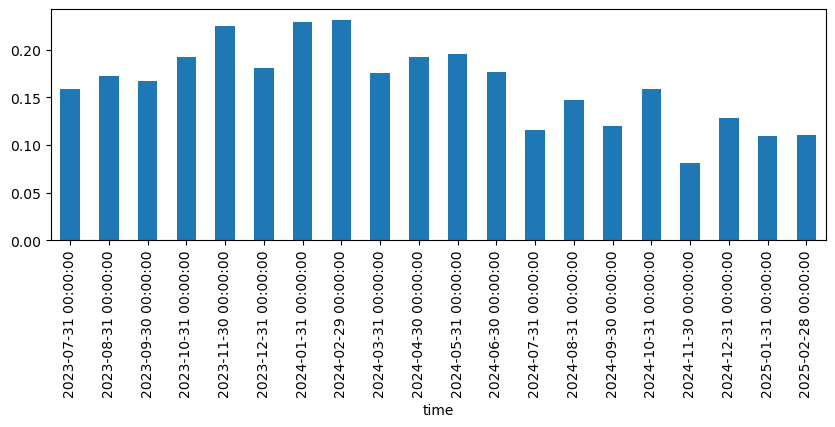

In [1114]:
mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            roc_auc_score(x['target'], x['y_pred'])
                                                                                                          ) - 0.5).plot.bar()

#### 2. WIN

In [1118]:
np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

0.22686240875366323

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/3700073749.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

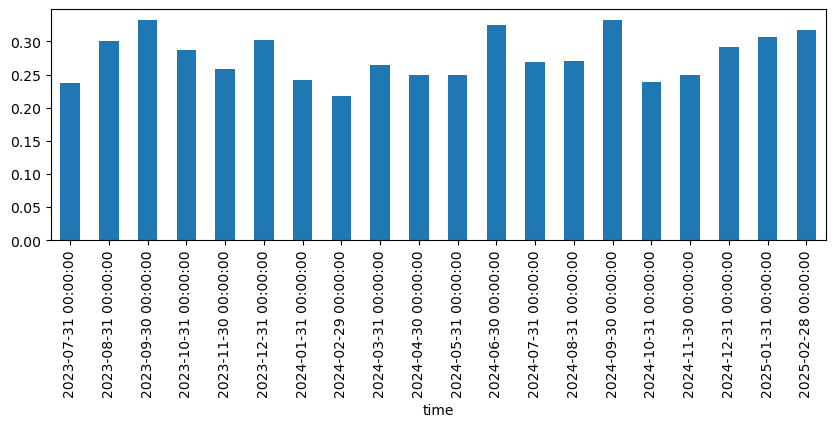

In [1120]:
q = 0.995
col_target = 'target'

mask_last_bin = df['y_pred'] >= np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()).plot.bar()

#### 3. income_rate

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/2532690047.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


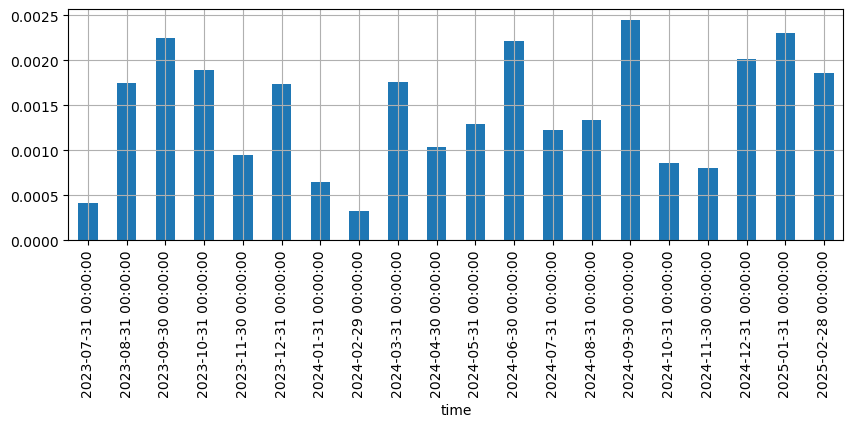

In [1122]:
q = 0.995
col_target = 'income_rate'

mask_last_bin = df['y_pred'] >= np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()) -1).plot.bar()
plt.grid()

#### 4. Отложенная выборка

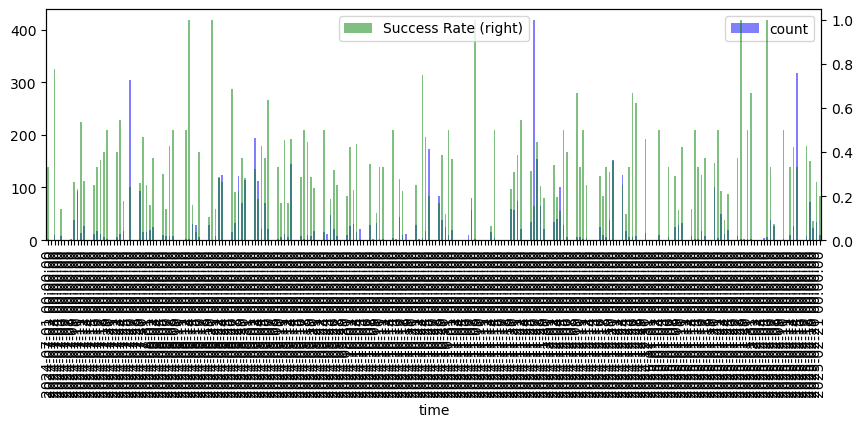

INCOME_RATE


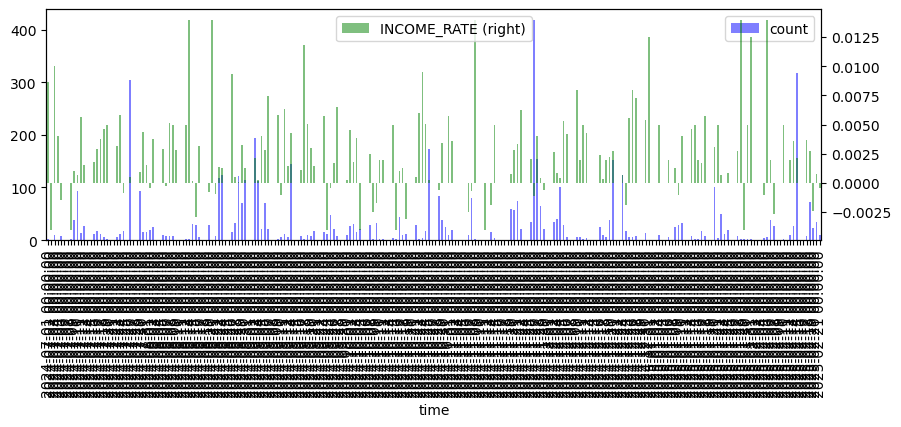

In [1124]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.995
freq='D'

mask_data = mask_valid|mask_test|mask_test2|mask_test3

threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] >= threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [1127]:
#y_test3

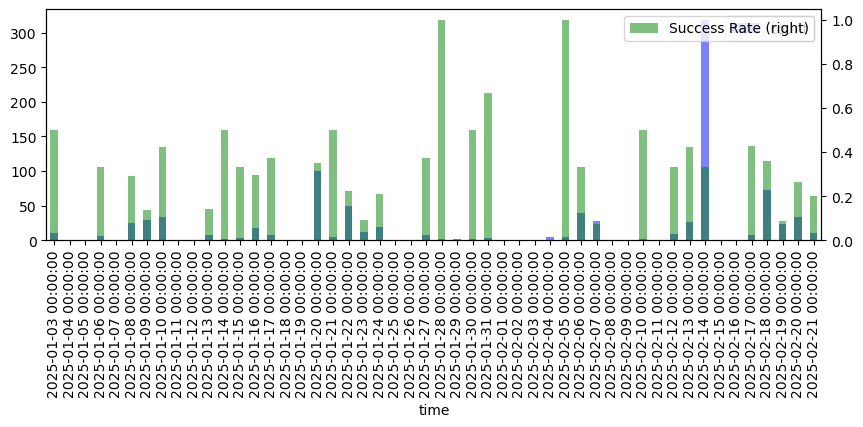

INCOME_RATE


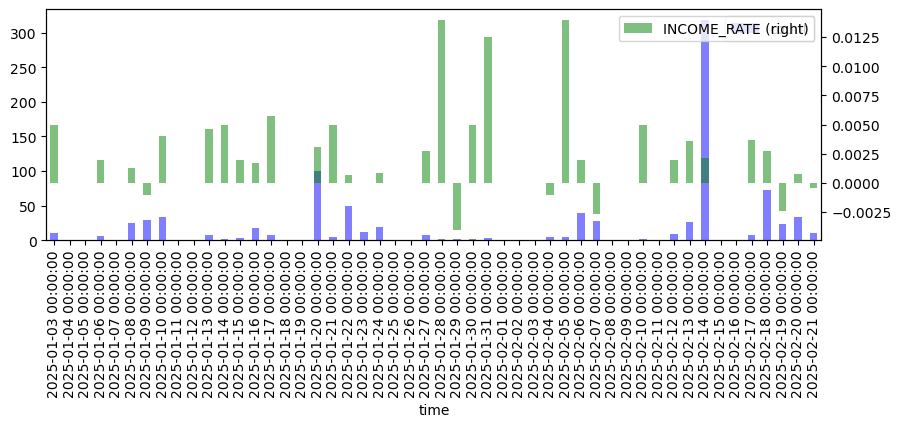

In [1129]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.995
freq='D'


mask_data = mask_test3


threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] >= threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [1132]:
#mean_income_rate_by_day
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()


(0.002809236145604034, 0.0023645536005738143, 0.0030097958228476546)

In [1134]:
df.loc[mask_valid&mask_last_bin, 'time'].dt.date.nunique(), df.loc[mask_test&mask_last_bin, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask_last_bin, 'time'].dt.date.nunique()


(44, 44, 37)

In [1136]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.995)

In [1138]:
#sum_income_rate
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06049424306550394, 0.049778267425649315, 0.05359498661153247)

In [1141]:
#test3
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()

0.0030187571083587226

In [1143]:
df.loc[mask_test3&mask_last_bin, 'time'].dt.date.nunique()

33

In [1145]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.055606090705674446

In [1149]:
mask_data = mask_valid | mask_test | mask_test2

In [1151]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/1640586492.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0006639938354492188

In [1154]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/1656526771.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0007162486965006048

In [1156]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/192763211.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0007945664904334328

In [1158]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/1559495362.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0004465773298933699

In [1160]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/2683039865.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0012062589327494304

#### Points in life

In [1164]:
threshold

0.22686240875366323

In [ ]:
mask_dev = df['time'] > pd.Timestamp('2025-01-20')
df.loc[mask_dev, 'y_pred'] = model.predict(df.loc[mask_dev, features_fe]) #feratures_fe

#threshold = 0.5695387939626755
df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: (x['y_pred'] >= threshold).sum())

### Обучить на всем

In [1337]:
features

['close_w30_lvl_1.015-1.02',
 'close_w30_lvl_1.02-1.03',
 'close_w120_lvl_1.02-1.03',
 'close/close_w5_expma',
 'close/close_w10_expma',
 'close/close_w20_expma',
 'close/close_w30_expma',
 'close/close_w60_expma',
 'close/close_w120_expma',
 'close_w5_expma/close_w20_expma',
 'close_w5_expma/close_w30_expma',
 'close_w5_expma/close_w60_expma',
 'close_w5_expma/close_w120_expma',
 'close_w10_expma/close_w30_expma',
 'close_w10_expma/close_w60_expma',
 'close_w10_expma/close_w120_expma',
 'close_w20_expma/close_w60_expma',
 'close_w20_expma/close_w120_expma',
 'close_w30_expma/close_w60_expma',
 'close_w30_expma/close_w120_expma']

In [1339]:
features_fe = features
cat_features = []
target = 'target'

In [1341]:
mask_data = mask_train | mask_valid | mask_test | mask_test2
#mask_data = (pd.Timestamp('2024-01-01') <= df['time']) &  (df['time'] < pd.Timestamp('2025-01-01'))
#print(mask_data.sum())
#mask_data = mask_valid | mask_test | mask_test2
#mask_data = mask_test2

D_data = lgbm.Dataset(df.loc[mask_data, features_fe], label=df.loc[mask_data, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_data.income_rate = df.loc[mask_data, 'income_rate'].values

D_data.time = df.loc[mask_data, 'time'].values

In [1343]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [1367]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 100,

    
    "num_leaves": 31,
    #"learning_rate": 0.001,
     "feature_fraction": 0.5,
     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     'lambda_l1' : 1,
     'lambda_l2' : 1,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    # "metric": "auc",
      "metric" : 'mean_income_rate',
     "early_stopping" : 10,



    
}

In [1369]:
#model.num_trees()

In [1371]:
#del params['metric'], params['early_stopping']

In [1373]:
#params['num_boost_round'] = 40

In [1375]:
model = lgbm.train(params, train_set=D_data, valid_sets=[D_test3], feval=mean_income_rate)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's mean_income_rate: 0.00141


In [1377]:
model.num_trees()

13

In [1352]:
#dump_pkl(model, 'model_-0.5_+1.5_4hour.pkl')

In [1354]:
#model = load_pkl('model_-0.5_+1.5_4hour.pkl')
#model.num_trees()

In [1379]:
y_pred_data= model.predict(D_data.data)


df["y_pred"] = None
df.loc[mask_data, 'y_pred'] = y_pred_data

roc_auc_score(D_data.label, y_pred_data)

0.6770638965364955

In [1382]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.6090700984894337

In [1386]:
THREHOLD = np.quantile(y_pred_test3, q=0.995)
#THRESHOLD = threshold
THRESHOLD

0.22686240875366323

In [1388]:
mean_income_rate_point(D_data, y_pred_data, threshold=THRESHOLD)

0.0026379170347794467

In [1391]:
mean_income_rate_day(D_data, y_pred_data, threshold=THRESHOLD)

0.0036637617789679307

In [1394]:
mean_income_rate_month(D_data, y_pred_data, threshold=THRESHOLD)

0.05208178282717489

In [1398]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0026117390072024627

In [1400]:
mean_income_rate_tick(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0026933455751055775

In [1402]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=THRESHOLD)

0.004326890513360705

In [1404]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=THRESHOLD)

0.05260587939928016

In [ ]:
# Стало лучше, но тут я обучался под valid

In [1221]:
# +-

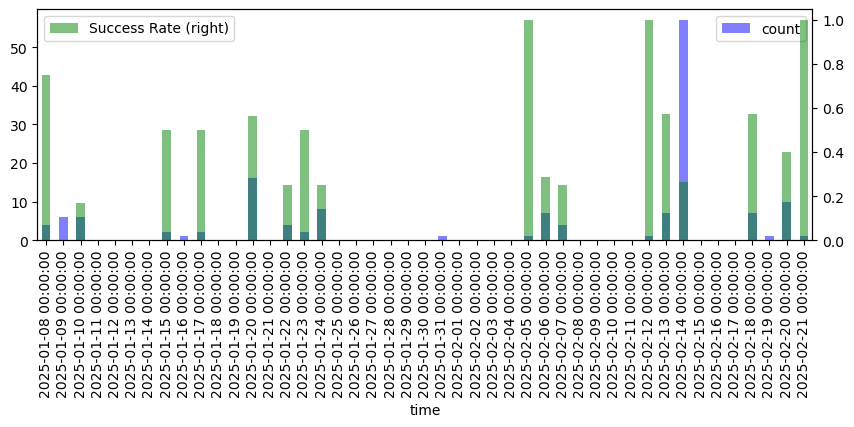

INCOME_RATE


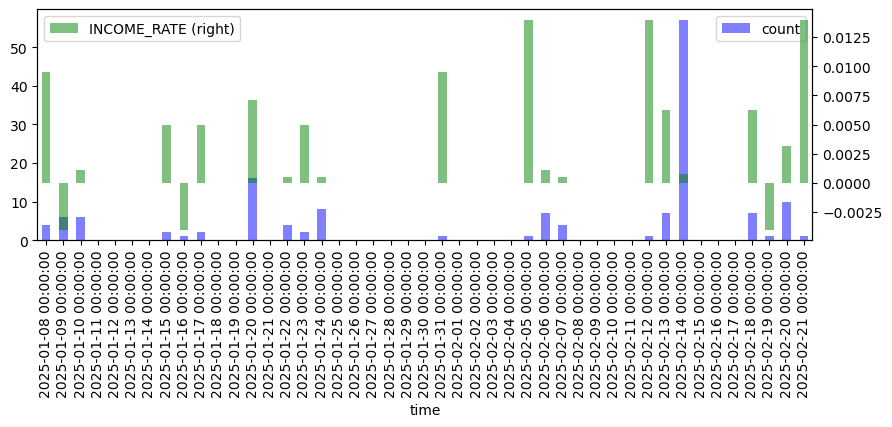

In [1406]:
#distibution in time
#win
col_pred = 'y_pred'
freq='D'


mask_data = mask_test3


#threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > THRESHOLD


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [1411]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_w20_expma/close_w120_expma', 18.4),
 ('close_w120_lvl_1.02-1.03', 16.46),
 ('close_w30_expma/close_w120_expma', 13.64),
 ('close/close_w5_expma', 8.8),
 ('close_w10_expma/close_w120_expma', 7.4),
 ('close/close_w10_expma', 5.55),
 ('close_w30_expma/close_w60_expma', 4.48),
 ('close_w5_expma/close_w120_expma', 3.96),
 ('close_w10_expma/close_w30_expma', 3.36),
 ('close/close_w30_expma', 2.44),
 ('close_w20_expma/close_w60_expma', 2.33),
 ('close/close_w120_expma', 2.16),
 ('close_w5_expma/close_w30_expma', 2.16),
 ('close_w10_expma/close_w60_expma', 2.1),
 ('close_w5_expma/close_w20_expma', 1.76),
 ('close_w5_expma/close_w60_expma', 1.74),
 ('close/close_w60_expma', 1.48),
 ('close_w30_lvl_1.015-1.02', 0.83),
 ('close/close_w20_expma', 0.8),
 ('close_w30_lvl_1.02-1.03', 0.12)]